In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Sepsis Detection using Machine Learning

# Exploratory Data Analysis

## Abstract
<font size="4">

- This data science project aimed to develop a highly performant predictive model for sepsis detection using comprehensive data analysis, feature engineering, imputation, model selection, and post-hoc analysis.
  
- The data analysis included the creation of temporal confidence intervals for each feature, between the sick and healthy patients (had/didnt have Sepsis). We saw a difference in the time dimension which leads us to our hypothesis that the temporal timestamps (i.e the time the patient spends in the ICU) and the change in features through their stays, had high impact on their sick/health state in the end.
  
- The project followed best practices and employed various frameworks, with an emphasis on feature engineering and imputation methods. A new feature named SIRS was developed, and the temporal dimension was encoded into tabular features using the <u>WindowMeanBucket</u> method, which proved to be the most complex but the most effective for sepsis detection.
  
- The model selection phase involved hyperparameter optimization on three models, and XGBoost was found to be the most performant, with 0.734 on the validation set and 0.718 on the test set, where the difference between the two sets can be explained by the fact that distributions might be different between the train and the test.
  
- The post-hoc analysis identified specific subpopulations in which the model performed well or poorly. 
  
  
- The project demonstrated the importance and necessity of each step in the data science pipeline, yielding valuable insights that can inform future research and clinical decision-making. </font>


## Loading Dataset

In [3]:
train_df = pd.read_csv('train_df.csv') ## generated offline as it takes a lot of time

In [4]:
print( f"Number of patients in the training dataset {len(list(set(list(train_df['patient'].values))))} ")

Number of patients in the training dataset 20000 


In [5]:
features_list = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS']

### Features description:

- **HR:** Heart rate in beats per minute (bpm)
- **O2Sat:** Oxygen saturation, the percentage of oxygen in the blood
- **Temp:** Body temperature in degrees Celsius (°C)
- **SBP:** Systolic blood pressure in millimeters of mercury (mmHg)
- **MAP:** Mean arterial pressure in mmHg
- **DBP:** Diastolic blood pressure in mmHg
- **Resp:** Respiratory rate in breaths per minute (bpm)
- **EtCO2:** End-tidal carbon dioxide, the concentration of carbon dioxide at the end of exhalation
- **BaseExcess:** Base excess in the blood, a measure of acid-base balance
- **HCO3:** Bicarbonate ion concentration in the blood, another measure of acid-base balance
- **FiO2:** Fraction of inspired oxygen, the concentration of oxygen in the air being breathed
- **pH:** Blood pH, a measure of acidity
- **PaCO2:** Partial pressure of carbon dioxide in the arterial blood
- **SaO2:** Arterial oxygen saturation, the percentage of hemoglobin saturated with oxygen in the arterial blood
- **AST:** Aspartate aminotransferase, an enzyme found in the liver
- **BUN:** Blood urea nitrogen, a measure of kidney function
- **Alkalinephos:** Alkaline phosphatase, an enzyme found in the liver, bones, and other tissues
- **Calcium:** Calcium ion concentration in the blood
- **Chloride:** Chloride ion concentration in the blood
- **Creatinine:** Creatinine concentration in the blood, another measure of kidney function
- **Bilirubin_direct:** Direct bilirubin concentration in the blood, a measure of liver function
- **Glucose:** Blood glucose concentration
- **Lactate:** Lactate concentration in the blood, a measure of tissue oxygenation
- **Magnesium:** Magnesium ion concentration in the blood
- **Phosphate:** Phosphate ion concentration in the blood
- **Potassium:** Potassium ion concentration in the blood
- **Bilirubin_total:** Total bilirubin concentration in the blood
- **TroponinI:** Troponin I concentration in the blood, a marker of heart muscle damage
- **Hct:** Hematocrit, the proportion of red blood cells in the blood
- **Hgb:** Hemoglobin concentration in the blood
- **PTT:** Partial thromboplastin time, a measure of blood clotting ability
- **WBC:** White blood cell count
- **Fibrinogen:** Fibrinogen concentration in the blood, a measure of blood clotting ability
- **Platelets:** Platelet count in the blood
- **Age:** Age of the patient
- **Gender:** Gender of the patient
- **HospAdmTime:** Time in hours between hospital admission and ICU admission
- **ICULOS:** ICU length of stay in hours

<font size="3.5">


### We can split the different features into categories:

#### Vital Signs:

HR, O2Sat, Temp, SBP, MAP, DBP, Resp, EtCO2

These features are essential vital signs that provide information on the patient's cardiovascular and respiratory status. Abnormal values may indicate the presence of sepsis or indicate disease severity.

#### Blood Chemistry:

BaseExcess, HCO3, FiO2, pH, PaCO2, SaO2, AST, BUN, Alkalinephos, Calcium, Chloride, Creatinine, Bilirubin_direct, Glucose, Lactate, Magnesium, Phosphate, Potassium, Bilirubin_total, TroponinI
These features measure various chemicals and enzymes in the blood that can indicate organ function and acid-base balance. Changes in these values can be indicative of sepsis or complications arising from the disease.

#### Hematology:

Hct, Hgb, PTT, WBC, Fibrinogen, Platelets
These features measure different aspects of blood composition and clotting ability. Abnormal values may indicate sepsis or a risk of bleeding or clotting complications.

#### Patient Demographics:
Age, Gender, HospAdmTime, ICULOS
These features provide information on patient demographics and hospital admission times. They may be used to identify risk factors for sepsis

 </font>

## Sepsis Vs No Sepsis patients statistics

In [6]:
sick_df = train_df[train_df.y == 1]
healthy_df = train_df[train_df.y == 0]

In [7]:
print(f"Total sick patients: {len(sick_df.patient.unique())}")
print(f"Total healthy patients: {len(healthy_df.patient.unique())}")
print(f"Number of patients that didn't get Sepsis is {round(len(healthy_df.patient.unique())/len(sick_df.patient.unique()), 3)} times than the patients who get sepsis")

Total sick patients: 1415
Total healthy patients: 18585
Number of patients that didn't get Sepsis is 13.134 times than the patients who get sepsis


### Stats about all the data of the patients that eventually got Sepsis

In [8]:
sick_df.describe()

Unnamed: 0 
 HR 
 O2Sat 
 Temp 
 SBP 
 MAP 
 DBP 
 Resp 
 EtCO2 
 BaseExcess 
 ... 
 Platelets 
 Age 
 Gender 
 Unit1 
 Unit2 
 HospAdmTime 
 ICULOS 
 SepsisLabel 
 timestamp 
 y 
 
 
 
 
 count 
 82795.000000 
 76790.000000 
 75060.000000 
 29602.000000 
 70539.000000 
 75417.000000 
 61295.000000 
 72090.000000 
 8376.000000 
 7503.000000 
 ... 
 5358.000000 
 82795.000000 
 82795.000000 
 42001.000000 
 42001.000000 
 82795.000000 
 82795.000000 
 82795.000000 
 82795.000000 
 82795.0 
 
 
 mean 
 371306.128075 
 88.398086 
 97.268072 
 37.139844 
 123.945632 
 81.797688 
 62.549511 
 19.909332 
 33.113658 
 -0.336166 
 ... 
 190.960853 
 62.589531 
 0.571303 
 0.516178 
 0.483822 
 -73.381779 
 60.095187 
 0.162836 
 58.524488 
 1.0 
 
 
 std 
 215343.158239 
 18.722675 
 3.053876 
 0.907249 
 24.158966 
 16.125347 
 13.668712 
 5.855446 
 7.568192 
 4.422008 
 ... 
 116.957379 
 16.308064 
 0.494893 
 0.499744 
 0.499744 
 178.439867 
 56.909826 
 0.369218 
 56.915564 
 0.0 
 
 
 min 
 23.000000 
 20.000000 
 21.000000 
 26.670000 
 43.000000 
 20.000000 
 21.000000 
 1.000000 
 10.000000 
 -19.000000 
 ... 
 2.000000 
 18.000000 
 0.000000 
 0.000000 
 0.000000 
 -2668.770000 
 1.000000 
 0.000000 
 0.000000 
 1.0 
 
 
 25% 
 187808.500000 
 75.000000 
 96.000000 
 36.600000 
 106.000000 
 71.000000 
 53.000000 
 16.000000 
 29.000000 
 -3.000000 
 ... 
 110.000000 
 53.000000 
 0.000000 
 0.000000 
 0.000000 
 -59.410000 
 17.000000 
 0.000000 
 15.000000 
 1.0 
 
 
 50% 
 362293.000000 
 87.000000 
 98.000000 
 37.170000 
 121.500000 
 80.000000 
 61.000000 
 19.000000 
 34.000000 
 0.000000 
 ... 
 173.500000 
 65.680000 
 1.000000 
 1.000000 
 0.000000 
 -3.310000 
 42.000000 
 0.000000 
 40.000000 
 1.0 
 
 
 75% 
 555036.500000 
 100.000000 
 100.000000 
 37.720000 
 140.000000 
 91.000000 
 70.000000 
 23.000000 
 38.000000 
 2.000000 
 ... 
 242.000000 
 73.920000 
 1.000000 
 1.000000 
 1.000000 
 -0.030000 
 85.000000 
 0.000000 
 84.000000 
 1.0 
 
 
 max 
 765742.000000 
 223.000000 
 100.000000 
 41.400000 
 299.000000 
 298.000000 
 287.000000 
 100.000000 
 98.000000 
 21.000000 
 ... 
 1081.000000 
 100.000000 
 1.000000 
 1.000000 
 1.000000 
 16.020000 
 336.000000 
 1.000000 
 335.000000 
 1.0 
 
 
 
 8 rows × 44 columns

In [9]:
sick_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82795 entries, 23 to 765742
Data columns (total 45 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        82795 non-null  int64  
 1   HR                76790 non-null  float64
 2   O2Sat             75060 non-null  float64
 3   Temp              29602 non-null  float64
 4   SBP               70539 non-null  float64
 5   MAP               75417 non-null  float64
 6   DBP               61295 non-null  float64
 7   Resp              72090 non-null  float64
 8   EtCO2             8376 non-null   float64
 9   BaseExcess        7503 non-null   float64
 10  HCO3              4702 non-null   float64
 11  FiO2              14061 non-null  float64
 12  pH                9331 non-null   float64
 13  PaCO2             7708 non-null   float64
 14  SaO2              4004 non-null   float64
 15  AST               1768 non-null   float64
 16  BUN               6667 non-null   floa

### Stats about all the data of the patients that didn't get Sepsis

In [10]:
healthy_df.describe()

Unnamed: 0 
 HR 
 O2Sat 
 Temp 
 SBP 
 MAP 
 DBP 
 Resp 
 EtCO2 
 BaseExcess 
 ... 
 Platelets 
 Age 
 Gender 
 Unit1 
 Unit2 
 HospAdmTime 
 ICULOS 
 SepsisLabel 
 timestamp 
 y 
 
 
 
 
 count 
 684089.000000 
 614123.000000 
 591622.000000 
 230546.000000 
 583513.000000 
 595661.000000 
 466402.000000 
 576453.000000 
 19065.000000 
 34573.000000 
 ... 
 40092.000000 
 684089.000000 
 684089.000000 
 425721.000000 
 425721.000000 
 684089.000000 
 684089.000000 
 684089.0 
 684089.000000 
 684089.0 
 
 
 mean 
 384910.238890 
 84.197185 
 97.181973 
 36.956169 
 123.463617 
 82.362794 
 63.950575 
 18.607007 
 32.999633 
 -0.837845 
 ... 
 197.491905 
 61.969412 
 0.553503 
 0.492849 
 0.507151 
 -52.830747 
 22.513677 
 0.0 
 21.061229 
 0.0 
 
 
 std 
 222055.215925 
 17.166226 
 2.939104 
 0.756490 
 23.040644 
 16.307548 
 13.923845 
 4.991442 
 8.166930 
 4.281205 
 ... 
 102.206001 
 16.423978 
 0.497130 
 0.499949 
 0.499949 
 167.400835 
 18.284782 
 0.0 
 18.302883 
 0.0 
 
 
 min 
 0.000000 
 20.000000 
 20.000000 
 20.900000 
 20.000000 
 20.000000 
 20.000000 
 1.000000 
 10.000000 
 -32.000000 
 ... 
 2.000000 
 15.000000 
 0.000000 
 0.000000 
 0.000000 
 -5366.860000 
 1.000000 
 0.0 
 0.000000 
 0.0 
 
 
 25% 
 192220.000000 
 72.000000 
 96.000000 
 36.500000 
 107.000000 
 71.000000 
 54.000000 
 15.000000 
 28.000000 
 -3.000000 
 ... 
 129.000000 
 51.310000 
 0.000000 
 0.000000 
 0.000000 
 -44.260000 
 10.000000 
 0.0 
 9.000000 
 0.0 
 
 
 50% 
 387485.000000 
 83.000000 
 98.000000 
 37.000000 
 121.000000 
 80.000000 
 62.000000 
 18.000000 
 33.000000 
 0.000000 
 ... 
 182.000000 
 64.000000 
 1.000000 
 0.000000 
 1.000000 
 -6.110000 
 20.000000 
 0.0 
 18.000000 
 0.0 
 
 
 75% 
 576605.000000 
 95.000000 
 99.000000 
 37.440000 
 138.000000 
 92.000000 
 72.000000 
 21.000000 
 38.000000 
 1.000000 
 ... 
 244.000000 
 74.000000 
 1.000000 
 1.000000 
 1.000000 
 -0.050000 
 32.000000 
 0.0 
 31.000000 
 0.0 
 
 
 max 
 766883.000000 
 280.000000 
 100.000000 
 50.000000 
 298.000000 
 300.000000 
 300.000000 
 100.000000 
 100.000000 
 49.500000 
 ... 
 2322.000000 
 100.000000 
 1.000000 
 1.000000 
 1.000000 
 17.340000 
 336.000000 
 0.0 
 335.000000 
 0.0 
 
 
 
 8 rows × 44 columns

In [11]:
healthy_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 684089 entries, 0 to 766883
Data columns (total 45 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        684089 non-null  int64  
 1   HR                614123 non-null  float64
 2   O2Sat             591622 non-null  float64
 3   Temp              230546 non-null  float64
 4   SBP               583513 non-null  float64
 5   MAP               595661 non-null  float64
 6   DBP               466402 non-null  float64
 7   Resp              576453 non-null  float64
 8   EtCO2             19065 non-null   float64
 9   BaseExcess        34573 non-null   float64
 10  HCO3              27107 non-null   float64
 11  FiO2              49736 non-null   float64
 12  pH                44423 non-null   float64
 13  PaCO2             35297 non-null   float64
 14  SaO2              22838 non-null   float64
 15  AST               10474 non-null   float64
 16  BUN               45

<font size="4">


Upon initial inspection of the data, it becomes apparent that there are a significant number of missing values in both the healthy and sick datasets. This presents a challenge that we will address during the missing data stage of our analysis. We will also use imputation techniques to fill in these missing values and ensure that our results are as accurate as possible.

## First, we wanted to examine time dimension

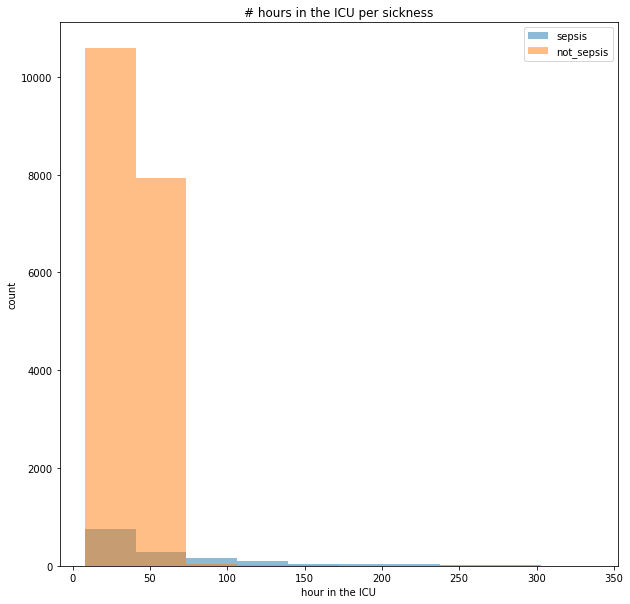

In [12]:
sick_df = train_df[train_df.y == 1]
count_timeseries_1 = sick_df.groupby('patient').count()['timestamp'].values
healthy_df = train_df[train_df.y == 0]
count_timeseries_0 = healthy_df.groupby('patient').count()['timestamp'].values
fig, ax = plt.subplots(figsize= (10,10))
ax.hist(count_timeseries_1, label='sepsis', alpha=0.5)
ax.hist(count_timeseries_0, label='not_sepsis', alpha=0.5)
ax.legend()
plt.xlabel('hour in the ICU')
plt.ylabel('count')
plt.title('# hours in the ICU per sickness')
plt.show()

<font size="5">

#### In order to examine more clearly the distributions, we'll limit the x axis

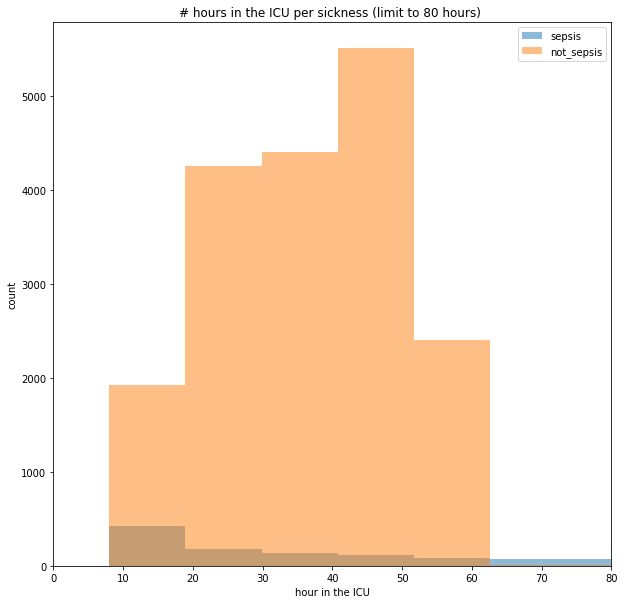

In [13]:
sick_df = train_df[train_df.y == 1]
count_timeseries_1 = sick_df.groupby('patient').count()['timestamp'].values
healthy_df = train_df[train_df.y == 0]
count_timeseries_0 = healthy_df.groupby('patient').count()['timestamp'].values
fig, ax = plt.subplots(figsize= (10,10))
ax.hist(count_timeseries_1,bins=30, label='sepsis', alpha=0.5)
ax.hist(count_timeseries_0,bins=30,  label='not_sepsis', alpha=0.5)
ax.legend()
ax.set_xlim(0,80)

plt.xlabel('hour in the ICU')
plt.ylabel('count')
plt.title('# hours in the ICU per sickness (limit to 80 hours) ')
plt.show()

<font size="3">

The above figure suggests a difference in ICU length of stay between patients with and without sepsis, with those without sepsis appearing to stay longer. One possible explanation for this finding is that patients without sepsis may have other underlying health conditions that require longer stays in the ICU. Another possible explanation could be that patients with sepsis may have had more severe illness and were more likely to die during their ICU stay, leading to a shorter length of stay. However, further investigation and analysis will be needed to confirm these hypotheses and better understand the relationship between sepsis and ICU length of stay.

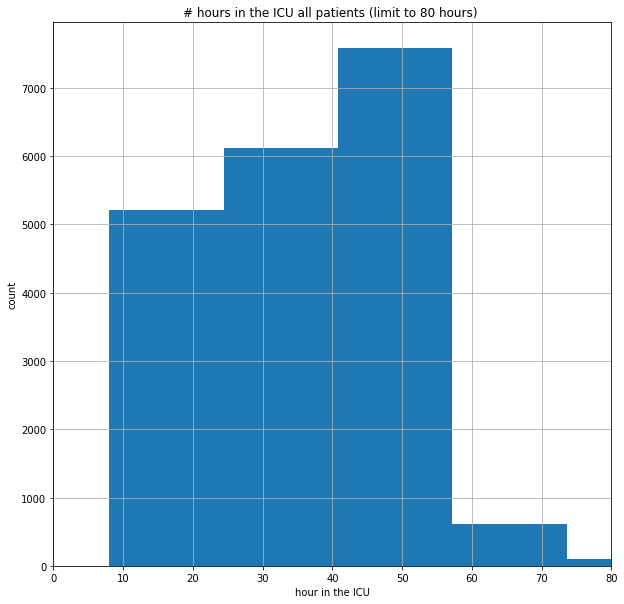

In [14]:
count_timeseries = train_df.groupby('patient').count()
count_timeseries['timestamp'].hist(bins=20, figsize= (10,10))
plt.xlim(0,80)
plt.xlabel('hour in the ICU')
plt.ylabel('count')
plt.title('# hours in the ICU all patients (limit to 80 hours) ')
plt.show()

## In order to perform the statistics correctly, we'll use only the rows that going to be used in our models

In [15]:
## taking only the relevant rows (6 hours before the sepsis occured) 
sick_df1 = train_df[train_df['y']==1]
sick_df_no_sepsis = sick_df1[sick_df1['SepsisLabel']==0]
sick_df_sepsis = sick_df1[sick_df1['SepsisLabel']==1]
sick_df_sepsis = sick_df_sepsis.groupby('patient').apply(lambda x: x[x['timestamp'] == x['timestamp'].min()]).reset_index(drop=True)
                 
sick_df_for_training = pd.concat([sick_df_no_sepsis, sick_df_sepsis])
sick_df_training = sick_df_for_training.sort_values(['patient', 'timestamp'])

In [16]:
sick_df_training.describe()

Unnamed: 0 
 HR 
 O2Sat 
 Temp 
 SBP 
 MAP 
 DBP 
 Resp 
 EtCO2 
 BaseExcess 
 ... 
 Platelets 
 Age 
 Gender 
 Unit1 
 Unit2 
 HospAdmTime 
 ICULOS 
 SepsisLabel 
 timestamp 
 y 
 
 
 
 
 count 
 70728.000000 
 65570.000000 
 64161.000000 
 25403.000000 
 60266.000000 
 64418.000000 
 52743.000000 
 61663.000000 
 7052.000000 
 6243.000000 
 ... 
 4427.000000 
 70728.000000 
 70728.000000 
 35393.000000 
 35393.000000 
 70728.000000 
 70728.000000 
 70728.000000 
 70728.000000 
 70728.0 
 
 
 mean 
 372854.362883 
 87.946660 
 97.325361 
 37.121392 
 124.392215 
 82.081268 
 62.632171 
 19.816799 
 33.195973 
 -0.403067 
 ... 
 190.780495 
 62.650687 
 0.569647 
 0.502303 
 0.497697 
 -73.039198 
 60.835737 
 0.020006 
 59.257889 
 1.0 
 
 
 std 
 215353.250584 
 18.591623 
 2.992295 
 0.874781 
 23.962369 
 16.046274 
 13.582555 
 5.800516 
 7.543724 
 4.313642 
 ... 
 115.797535 
 16.259906 
 0.495129 
 0.500002 
 0.500002 
 176.926172 
 56.557057 
 0.140022 
 56.575482 
 0.0 
 
 
 min 
 23.000000 
 20.000000 
 21.000000 
 26.670000 
 43.000000 
 20.000000 
 22.000000 
 1.000000 
 10.000000 
 -19.000000 
 ... 
 6.000000 
 18.000000 
 0.000000 
 0.000000 
 0.000000 
 -2668.770000 
 1.000000 
 0.000000 
 0.000000 
 1.0 
 
 
 25% 
 188911.750000 
 75.000000 
 96.000000 
 36.600000 
 107.000000 
 71.000000 
 53.500000 
 16.000000 
 29.000000 
 -3.000000 
 ... 
 110.000000 
 53.000000 
 0.000000 
 0.000000 
 0.000000 
 -55.540000 
 18.000000 
 0.000000 
 16.000000 
 1.0 
 
 
 50% 
 362601.500000 
 87.000000 
 98.000000 
 37.110000 
 122.000000 
 80.000000 
 61.000000 
 19.000000 
 34.000000 
 0.000000 
 ... 
 175.000000 
 65.805000 
 1.000000 
 1.000000 
 0.000000 
 -3.460000 
 43.000000 
 0.000000 
 41.000000 
 1.0 
 
 
 75% 
 555432.250000 
 100.000000 
 100.000000 
 37.700000 
 140.000000 
 91.330000 
 70.000000 
 23.000000 
 38.000000 
 2.000000 
 ... 
 241.000000 
 73.900000 
 1.000000 
 1.000000 
 1.000000 
 -0.030000 
 86.000000 
 0.000000 
 85.000000 
 1.0 
 
 
 max 
 765734.000000 
 223.000000 
 100.000000 
 41.400000 
 299.000000 
 298.000000 
 287.000000 
 100.000000 
 98.000000 
 19.000000 
 ... 
 961.000000 
 100.000000 
 1.000000 
 1.000000 
 1.000000 
 16.020000 
 331.000000 
 1.000000 
 330.000000 
 1.0 
 
 
 
 8 rows × 44 columns

In [17]:
sick_df_training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70728 entries, 23 to 1414
Data columns (total 45 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        70728 non-null  int64  
 1   HR                65570 non-null  float64
 2   O2Sat             64161 non-null  float64
 3   Temp              25403 non-null  float64
 4   SBP               60266 non-null  float64
 5   MAP               64418 non-null  float64
 6   DBP               52743 non-null  float64
 7   Resp              61663 non-null  float64
 8   EtCO2             7052 non-null   float64
 9   BaseExcess        6243 non-null   float64
 10  HCO3              3973 non-null   float64
 11  FiO2              11832 non-null  float64
 12  pH                7689 non-null   float64
 13  PaCO2             6304 non-null   float64
 14  SaO2              3219 non-null   float64
 15  AST               1373 non-null   float64
 16  BUN               5564 non-null   float6

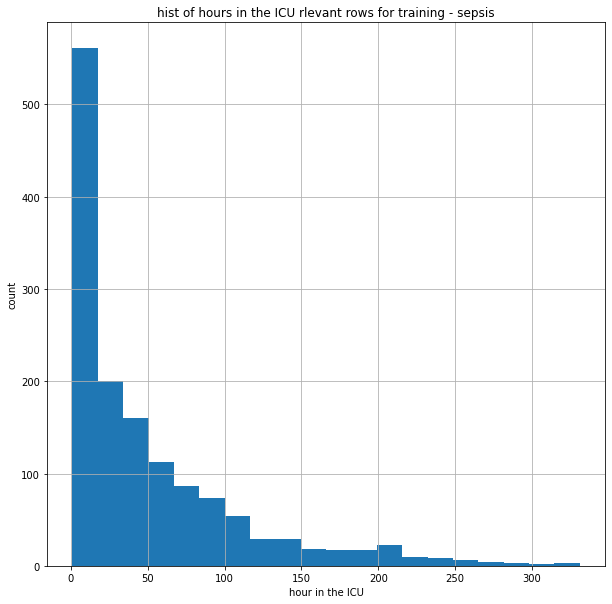

In [18]:
count_timeseries = sick_df_training.groupby('patient').count()
count_timeseries['timestamp'].hist(bins=20, figsize= (10,10))
plt.title('hist of hours in the ICU rlevant rows for training - sepsis')
plt.xlabel('hour in the ICU')
plt.ylabel('count')
plt.show()

<font size="3">

### The patients were categorized into three groups based on their length of stay in the ICU: those who spent a long time (approximately 72 hours), those who spent a moderate amount of time (between 24 and 72 hours), and those who spent a short amount of time (less than 24 hours).

In [19]:
sick_grouped = sick_df_training.groupby('patient').agg({'patient':['first'], 'timestamp':['max']}).reset_index()
sick_grouped.columns = ['_'.join(col) for col in sick_grouped.columns.values]
sick_grouped = sick_grouped[['patient_first', 'timestamp_max']]
sick_grouped = sick_grouped.rename(columns={'patient_first': 'patient'})
sick_united = pd.merge(sick_df_training, sick_grouped, on= 'patient',how='inner')

In [20]:
fast_sick = sick_united[sick_united['timestamp_max']<24]
med_sick = sick_united[(sick_united['timestamp_max']>=24) & (sick_united['timestamp_max']<72)]
slow_sick = sick_united[sick_united['timestamp_max']>=72]

In [21]:
healthy_df_grouped = healthy_df.groupby('patient').agg({'patient':['first'], 'timestamp':['max']}).reset_index()
healthy_df_grouped.columns = ['_'.join(col) for col in healthy_df_grouped.columns.values]
healthy_df_grouped = healthy_df_grouped[['patient_first', 'timestamp_max']]
healthy_df_grouped = healthy_df_grouped.rename(columns={'patient_first': 'patient'})
healthy_df_united = pd.merge(healthy_df, healthy_df_grouped, on= 'patient',how='inner')

In [22]:
fast_healthy = healthy_df_united[healthy_df_united['timestamp_max']<24]
med_healthy= healthy_df_united[(healthy_df_united['timestamp_max']>=24) & (healthy_df_united['timestamp_max']<72)]
slow_healthy = healthy_df_united[healthy_df_united['timestamp_max']>=72]

<font size="3">

### Inspecting the features' distribution, comparative analysis between features

In [23]:
features_list_con = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp',
       'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST',
       'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine',
       'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate',
       'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets']

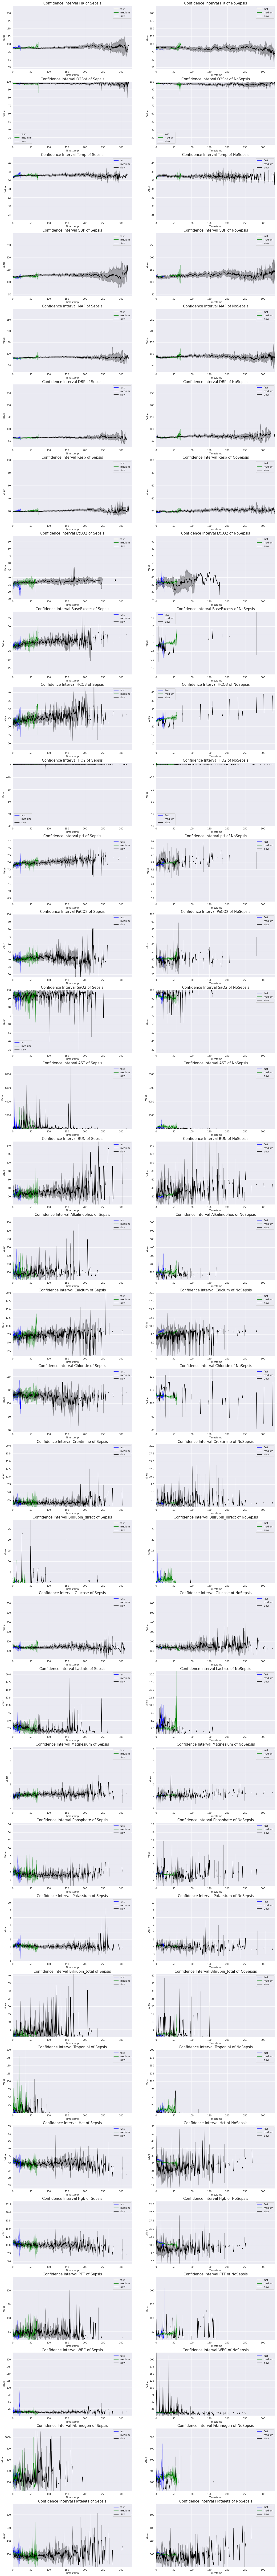

In [24]:
sick_dfs = {'fast': fast_sick, 'medium': med_sick, 'slow': slow_sick}
healthy_dfs = {'fast': fast_healthy, 'medium': med_healthy, 'slow': slow_healthy}

colors = {'fast': 'blue', 'medium': 'green', 'slow': 'black'}

sns.set_style('darkgrid')
# Step 2: Compute confidence interval
confidence_level = 0.95
z_score = 1.96  # For 95% confidence interval (assuming normal distribution)
width = 8
aspect_ratio = width / 300
figsize = (width*1.2, aspect_ratio*4*1.2)
min_val_x, max_val_x = sick_df_training['timestamp'].min(), sick_df_training['timestamp'].max()
min_val_x2, max_val_x2 = healthy_df['timestamp'].min(), healthy_df['timestamp'].max()

num_cols = len(features_list_con)
fig, axes = plt.subplots(nrows = num_cols, ncols = 2, figsize=(20,200))
for i, col in enumerate(features_list_con):
    # plt.suptitle(f'Confidence Interval {col}', fontsize=15)  # Set font size for title
    min_val_y, max_val_y = sick_df_training[col].min(), sick_df_training[col].max()
    min_val_y2, max_val_y2 = healthy_df[col].min(), healthy_df[col].max()
    for type_p, curr_df in sick_dfs.items():
        mini_train_df = curr_df.drop(columns=['y', 'SepsisLabel'])
        grouped_df = mini_train_df.groupby('timestamp')
        ts = np.arange(len(grouped_df.mean()))
        mean_df = grouped_df.mean()
        std_df = grouped_df.std()

        ci_lower = mean_df - z_score * (std_df / np.sqrt(grouped_df.count()))
        ci_upper = mean_df + z_score * (std_df / np.sqrt(grouped_df.count()))


        # Set the color for plot and fill_between based on the label
        color = colors[type_p]
        axes[i, 0].plot(ts, mean_df[col], label=type_p, color=color)
        axes[i, 0].fill_between(ts, ci_lower[col], ci_upper[col], alpha=0.3, color=color)
    
    for type_p, curr_df in healthy_dfs.items():
        mini_train_df = curr_df.drop(columns=['y', 'SepsisLabel'])
        grouped_df = mini_train_df.groupby('timestamp')
        ts = np.arange(len(grouped_df.mean()))
        mean_df = grouped_df.mean()
        std_df = grouped_df.std()

        ci_lower = mean_df - z_score * (std_df / np.sqrt(grouped_df.count()))
        ci_upper = mean_df + z_score * (std_df / np.sqrt(grouped_df.count()))


        # Set the color for plot and fill_between based on the label
        color = colors[type_p]
        axes[i, 1].plot(ts, mean_df[col], label=type_p, color=color)
        axes[i, 1].fill_between(ts, ci_lower[col], ci_upper[col], alpha=0.3, color=color)
    


    axes[i, 0].set_ylim(min_val_y, max_val_y)
    axes[i, 0].set_xlim(min_val_x, max_val_x)
    axes[i, 0].set_title(f'Confidence Interval {col} of Sepsis', fontsize=15)
    axes[i, 1].set_ylim(min_val_y, max_val_y)
    axes[i, 1].set_xlim(min_val_x2, max_val_x2)
    axes[i, 1].set_title(f'Confidence Interval {col} of NoSepsis', fontsize=15)

    axes[i, 1].legend()
    axes[i, 0].legend()
    axes[i, 0].set_xlabel('Timestamp')
    axes[i, 0].set_ylabel('Value')
    axes[i, 1].set_xlabel('Timestamp')
    axes[i, 1].set_ylabel('Value')

# plt.tight_layout()
plt.show()

<font size="4">


## Conclusion and Explanations:
- We can see the patients that didn't get sepsis have normal distribution of the time spent in the ICU, in contrast to the patients that did get sepsis who have long tale distribution.

- The temporal distribution of the sepsis patients is very intuitive since sepsis is a very deadly disease (~40% survival rate) that could cause quick death. More patients will spend short time in the ICU, and less patients (who maybe got the sepsis in the ICU) spend long time in the ICU.

- Looking at the distributions of the features through time we can see that some of the distributions are very different between sepsis and no sepsis patients what can lead us to the conclusion the those features will be important for our model in the end. 


- <u> Interesting insights:</u>
    -  **glucose levels** of people that didn't get sepsis are much higher through time than those of sepsis patients.
    -  Some features have more fluctuation in the healthy patients - HGB, HCT and WBC, while others have the opposite (i.e more fluctuation in the sick patients).

In [25]:
sick_df = train_df[train_df.y == 1]
healthy_df = train_df[train_df.y == 0]
sick_df_mean = sick_df.groupby('patient').mean()
healthy_df_mean = healthy_df.groupby('patient').mean()
sick_df_max = sick_df.groupby('patient').max()
healthy_df_max =  healthy_df.groupby('patient').max()

sick_df_training_mean = sick_df_training.groupby('patient').mean()
sick_df_training_max = sick_df_training.groupby('patient').max()

# Features' Statistics and Distribution 
### We'll examine all the hypothesis tests using significant level of: $\alpha$ = 0.05

In [26]:
from scipy.stats import ttest_ind
from statsmodels.stats.weightstats import ztest
alpha = 0.05

## Demographic feature analysis

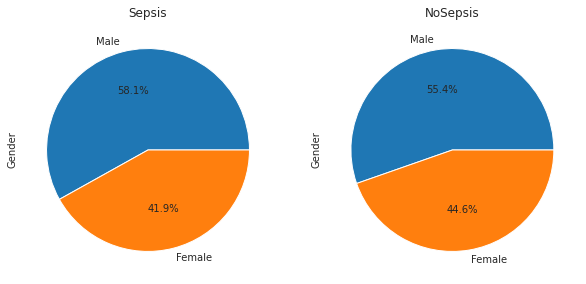

In [27]:
# Pie chart for 'Gender' in sick_df_mean
fig, axes = plt.subplots(ncols=2)
sick_df_mean['Gender'].value_counts().plot.pie(figsize=(10, 10), ax = axes[0], title= 'Sepsis', autopct='%1.1f%%', labels=['Male', 'Female'])
healthy_df_mean['Gender'].value_counts().plot.pie(figsize=(10, 10), ax = axes[1], title = 'NoSepsis', autopct='%1.1f%%', labels=['Male', 'Female'])
plt.show()

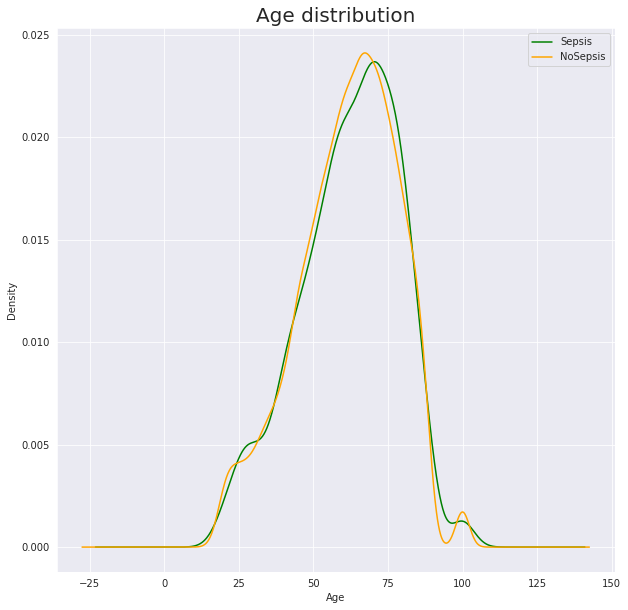

In [28]:
sick_df_mean.Age.plot.density(color='green', figsize=(10,10), label='Sepsis')
healthy_df_mean.Age.plot.density(color='orange',  figsize=(10,10), label='NoSepsis')
plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Age distribution', fontsize =20)
plt.legend()
plt.show()

### We can see normal distribution thus we can perform T test

In [29]:
t_stat, p_val = ttest_ind(sick_df_mean['Age'], healthy_df_mean['Age'])

print(f"t-statistic: {round(t_stat, 3)}, p-value: {round(p_val, 3)}")
if p_val < 0.05:
    print('There is significant difference')
else:
    print('There is no significant difference')

t-statistic: 1.38, p-value: 0.168
There is no significant difference


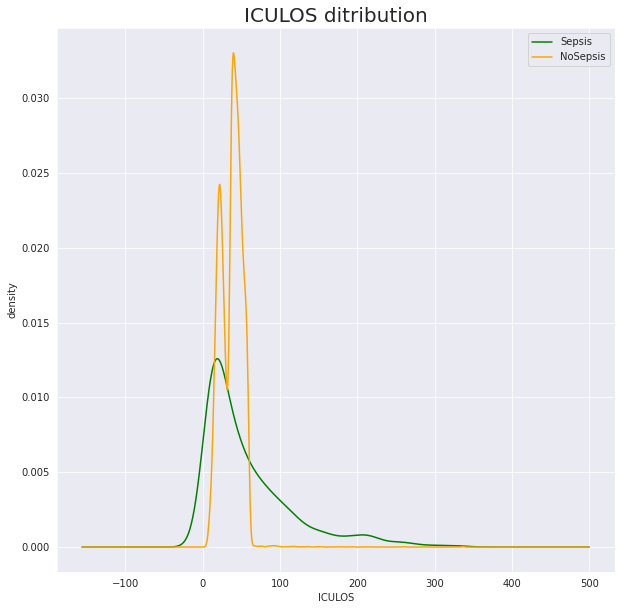

In [30]:
sick_df_max.ICULOS.plot.density(color='green', figsize=(10,10), label='Sepsis')
healthy_df_max.ICULOS.plot.density(color='orange',  figsize=(10,10), label='NoSepsis')
plt.xlabel('ICULOS')
plt.ylabel('density')
plt.title('ICULOS ditribution', fontsize =20)
plt.legend()
plt.show()

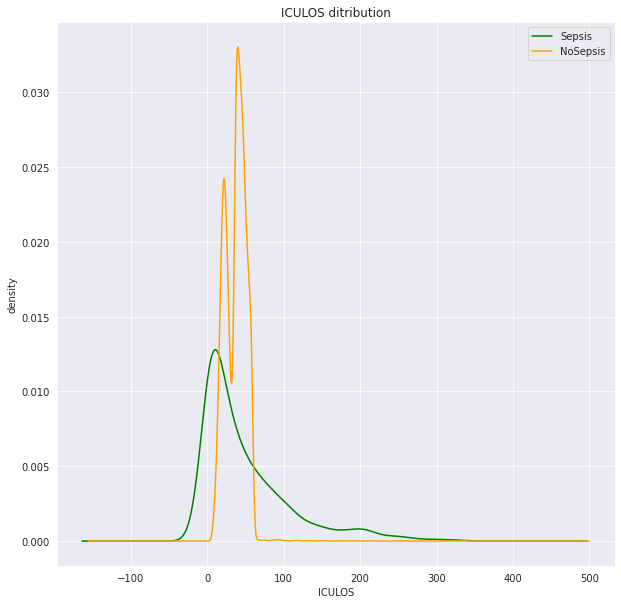

In [31]:
sick_df_training_max.ICULOS.plot.density(color='green', figsize=(10,10), label='Sepsis')
healthy_df_max.ICULOS.plot.density(color='orange',  figsize=(10,10), label='NoSepsis')
plt.xlabel('ICULOS')
plt.ylabel('density')
plt.title('ICULOS ditribution')
plt.legend()
plt.show()

### We can see the distribution isn't normal, thus we can't perform t-test - we'll perform z-test instead

In [32]:

z_stat, p_val = ztest(sick_df_max['ICULOS'].dropna(), healthy_df_max['ICULOS'].dropna())

print(f"z-statistic: {round(z_stat, 2)}, p-value: {p_val}")
if p_val < 0.05:
    print('There is significant difference')
else:
    print('There is no significant difference')

z-statistic: 36.67, p-value: 2.3908980910550203e-294
There is significant difference


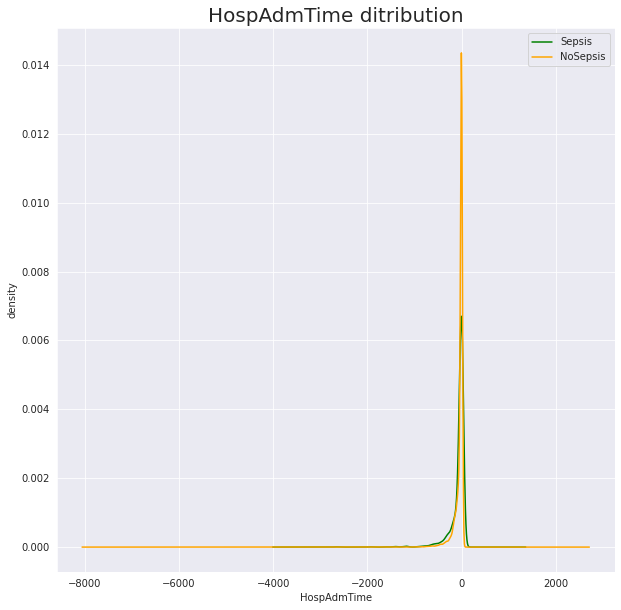

In [33]:
sick_df_mean.HospAdmTime.plot.density(color='green', figsize=(10,10), label='Sepsis')
healthy_df_mean.HospAdmTime.plot.density(color='orange',  figsize=(10,10), label='NoSepsis')
plt.xlabel('HospAdmTime')
plt.ylabel('density')
plt.title('HospAdmTime ditribution', fontsize = 20)
plt.legend()
plt.show()

### We can see the distribution isn't normal, thus we can't perform t-test - we'll perform z-test instead

In [34]:
from statsmodels.stats.weightstats import ztest
z_stat, p_val = ztest(sick_df_training_mean['HospAdmTime'].dropna(), healthy_df_mean['HospAdmTime'].dropna())

print(f"z-statistic: {z_stat}, p-value: {p_val}")
if p_val < 0.05:
    print('There is significant difference')
else:
    print('There is no significant difference')

z-statistic: -6.612467897076955, p-value: 3.7796510185227514e-11
There is significant difference


## Vital signs and Laboratory measurements  

In [35]:
columns = list(sick_df_mean.columns)
columns_to_drop = ['HospAdmTime', 'Age', 'Gender', 'ICULOS', 'Unnamed: 0',  'Unit1', 'Unit2','SepsisLabel', 'timestamp', 'y']
columns = [x for x in columns if x not in columns_to_drop]

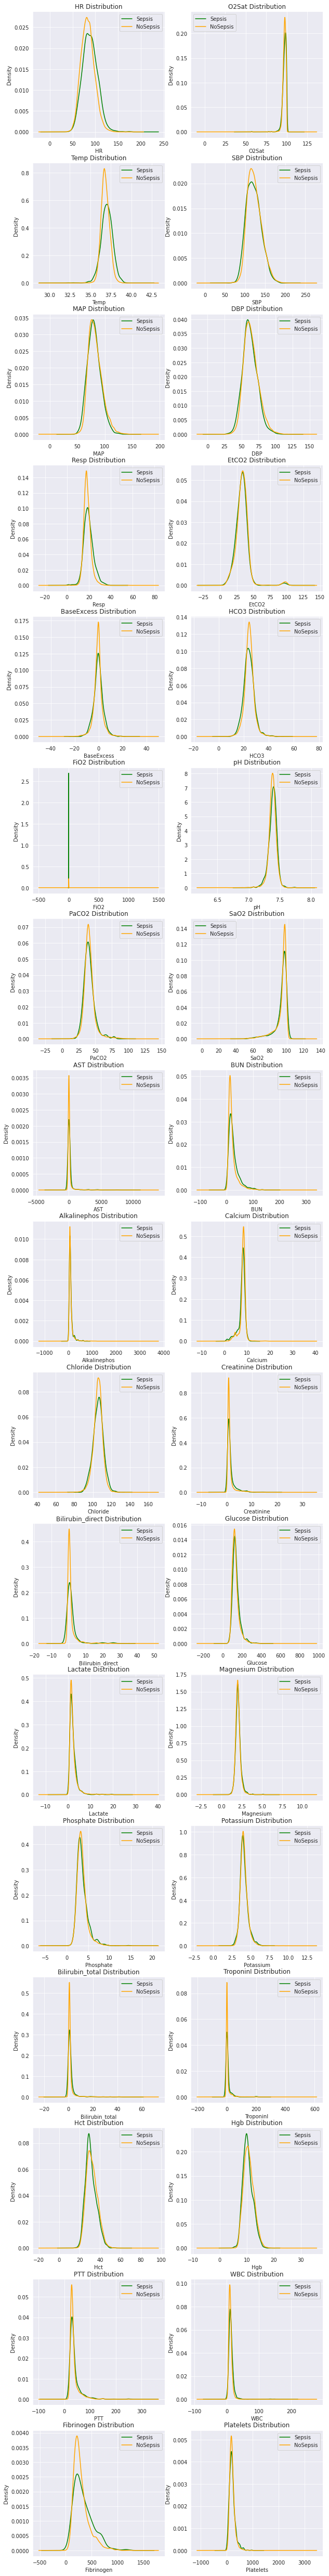

In [36]:
import seaborn as sns
# Set the figure size and create the subplots
fig, axes = plt.subplots(nrows=17, ncols=2, figsize=(10, 90))

# Iterate over the columns and plot their densities
for i, col in enumerate(columns):
    # Calculate the subplot indices based on the current column index
    row_idx = i // 2
    col_idx = i % 2

    # Plot the density curves on the current subplot
    sick_df_training_mean[col].plot.density(color='green', ax = axes[row_idx, col_idx])
    healthy_df_mean[col].plot.density(color='orange',  ax = axes[row_idx, col_idx])


    # Set the subplot title and axis labels
    axes[row_idx, col_idx].set_title(f"{col} Distribution")
    axes[row_idx, col_idx].set_xlabel(col)
    axes[row_idx, col_idx].set_ylabel('Density')
    axes[row_idx, col_idx].legend(labels=['Sepsis', 'NoSepsis'])
# Add a legend to the figure
# fig.legend(labels=['Sepsis', 'NoSepsis'], loc='upper right')

# Show the plot
plt.show()

In [37]:
normal_distributed_cols = ['HR', 'Temp',  'SBP',  'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'pH', 'PaCO2', 'SaO2',
 'Chloride', 'Magnesium', 'Phosphate', 'Potassium', 'Hct', 'Hgb', 'Fibrinogen']
unnormal_distributed_cols = ['O2Sat', 'FiO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Creatinine', 'Bilirubin_direct', 'Glucose', 
                             'Lactate', 'Bilirubin_total', 'TroponinI', 'PTT', 'WBC', 'Platelets']

### Perform tests for parameters that are not normally distributed

In [38]:
bold_start = '\033[1m'
bold_end   = '\033[0m'
count_normal = 0

for col in unnormal_distributed_cols:
    z_stat, p_val = ztest(sick_df_training_mean[col].dropna(), healthy_df_mean[col].dropna())
    print(bold_start, col, bold_end)
    print(f"z-statistic: {z_stat}, p-value: {p_val}")
    if p_val < 0.05:
        print('There is significant difference')
        count_normal +=1
    else:
        print('There is no significant difference')
print(bold_start, f"{count_normal} rejected hypotheses", bold_end)

 O2Sat 
z-statistic: 1.9550567179632055, p-value: 0.05057637613607899
There is no significant difference
 FiO2 
z-statistic: -0.2686498425416868, p-value: 0.788199152960471
There is no significant difference
 AST 
z-statistic: 0.9008224930425376, p-value: 0.3676827061741088
There is no significant difference
 BUN 
z-statistic: 8.08410036273843, p-value: 6.262474558164482e-16
There is significant difference
 Alkalinephos 
z-statistic: -0.8109409762764076, p-value: 0.41739956724327953
There is no significant difference
 Calcium 
z-statistic: -8.424584529557961, p-value: 3.620325606003573e-17
There is significant difference
 Creatinine 
z-statistic: 3.0083109322854273, p-value: 0.0026270420710423257
There is significant difference
 Bilirubin_direct 
z-statistic: 1.266406812892949, p-value: 0.20536747303170644
There is no significant difference
 Glucose 
z-statistic: 4.960024119169685, p-value: 7.048442764404924e-07
There is significant difference
 Lactate 
z-statistic: -0.2180610285963129

### Perform tests for parameters that are normally distributed

In [39]:
bold_start = '\033[1m'
bold_end   = '\033[0m'

count_not_normal = 0
for col in normal_distributed_cols:
    z_stat, p_val = ztest(sick_df_training_mean[col].dropna(), healthy_df_mean[col].dropna())
    print(bold_start, col, bold_end)
    print(f"z-statistic: {z_stat}, p-value: {p_val}")
    if p_val < 0.05:
        print('There is significant difference')
        count_not_normal+=1
    else:
        print('There is no significant difference')

print(bold_start, f"{count_not_normal} rejected hypotheses", bold_end)

 HR 
z-statistic: 12.26068175577049, p-value: 1.4725573669116635e-34
There is significant difference
 Temp 
z-statistic: 10.974939919498434, p-value: 5.043937619069171e-28
There is significant difference
 SBP 
z-statistic: -3.5956106457402526, p-value: 0.00032363153697796617
There is significant difference
 MAP 
z-statistic: -5.707070889925457, p-value: 1.1493692100581253e-08
There is significant difference
 DBP 
z-statistic: -4.8291184843571395, p-value: 1.3713879384064343e-06
There is significant difference
 Resp 
z-statistic: 12.030107738417763, p-value: 2.4683844912197443e-33
There is significant difference
 EtCO2 
z-statistic: -1.2272131998083484, p-value: 0.21974246950617338
There is no significant difference
 BaseExcess 
z-statistic: 1.6251406220106535, p-value: 0.10413259900278767
There is no significant difference
 HCO3 
z-statistic: -2.5844086246287334, p-value: 0.00975461482393421
There is significant difference
 pH 
z-statistic: 2.307940295419063, p-value: 0.021002457451780

<font size="3">


## Conclusions and Explanations:
- Since we have data that corresponds to time series - we have a sample of data for each patient for an hour that he spent in the ICU, we wanted to choose a single value in order to compare features' distribution. In our case, we want to examine the abnormal values, that maybe cause the patients to get sepsis, thus we decided to use the features' average value that is sensitive to extreme measures. 


- For the normally distributed features, we chose to use the t-test for the hypothesis testing, and for the features that don't have normal distribution, we chose to use the z-test for our hypothesis testing. 


- We chose a significant level of 0.05


- We divided the feature set into 3: demographic, vital signs, laboratory values. 


- Demographic features: Age, Gender, ICULOS, HospAdmTime.
- 
   The ICULOS is the length of stay in the ICU - thus only the final value matters - we used max values (instead of avg) for this feature. 


   HospAdmTime is the time between the hospitalization to the ICU admit. We saw in both ICULOS and HospAdmTime we can reject the null hypothesis and say that there is a significant difference between the two groups.


   It seems that the distribution of Age and Gender is similar between Sepsis and NoSepsis patients

- We explored the Vital signs and the Laboratory values all together. In total, 18 out of 34 hypotheses were rejected, which represents approximately 50%. When comparing patients with and without sepsis, most measures exhibit comparable distributions. However, in the majority of features, the distribution for patients with sepsis (indicated by the green color) appears to be slightly broader, indicating greater variability in the values. This observation is reasonable, as it is expected that an abnormal medical condition would result in distinct measures compared to when the condition is absent, specifically more extreme measures.

## Features correlations

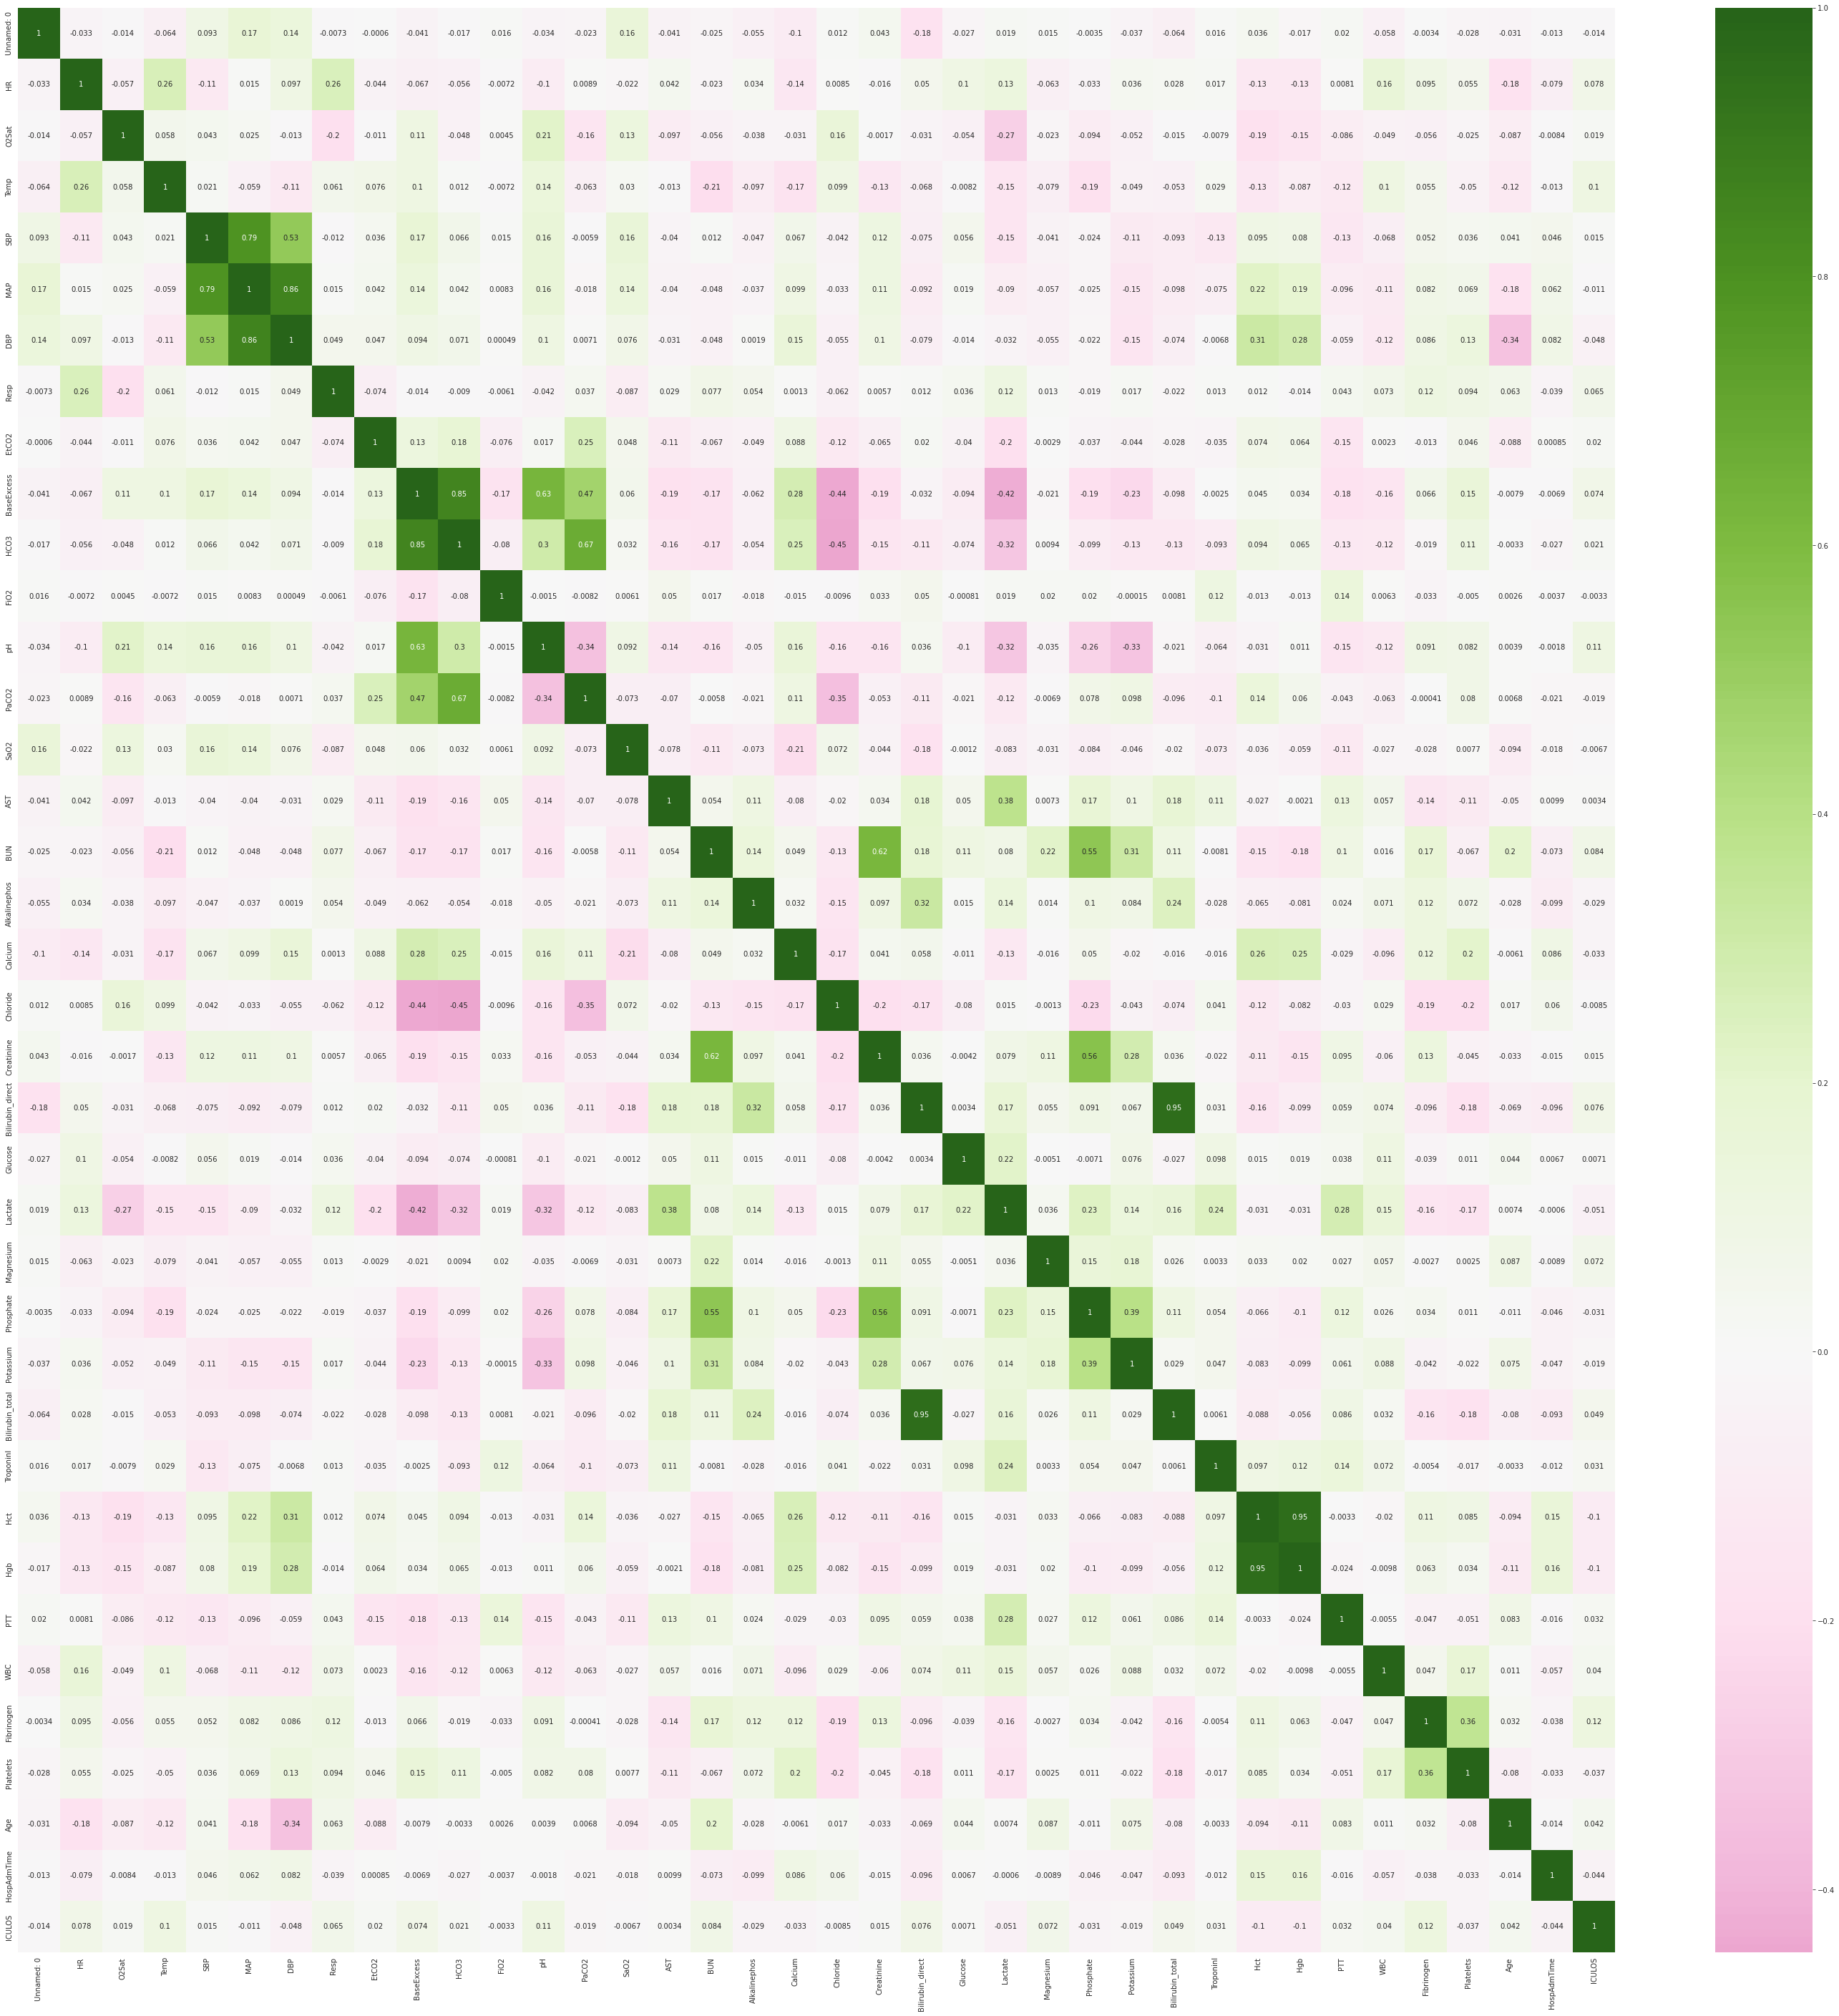

In [56]:
dfs_median = []


train_df_training = pd.concat([sick_df_for_training, healthy_df])
train_df_training_mean = train_df_training.groupby('patient').mean()
train_df_training_for_corr = train_df_training_mean.drop(columns=['y','SepsisLabel', 'Gender', 'Unit1', 'Unit2', 'timestamp'])
train_df_training_corr = train_df_training_for_corr.corr()

plt.figure(figsize=(50,50))
sns.heatmap(train_df_training_corr, annot=True, robust=False, cmap="PiYG", center = 0)
plt.show()

<font size="4">

**From the analysis, it is apparent that certain groups of features display positive or negative correlations with each other. For instance, a strong positive correlation is observed among the SBP, DBP, and MAP features, which are all related to blood pressure measurements. This outcome is therefore sensible and expected.**

# Missing data analysis

Text(0.5, 1.0, 'Quantifying missing data -Sepsis')

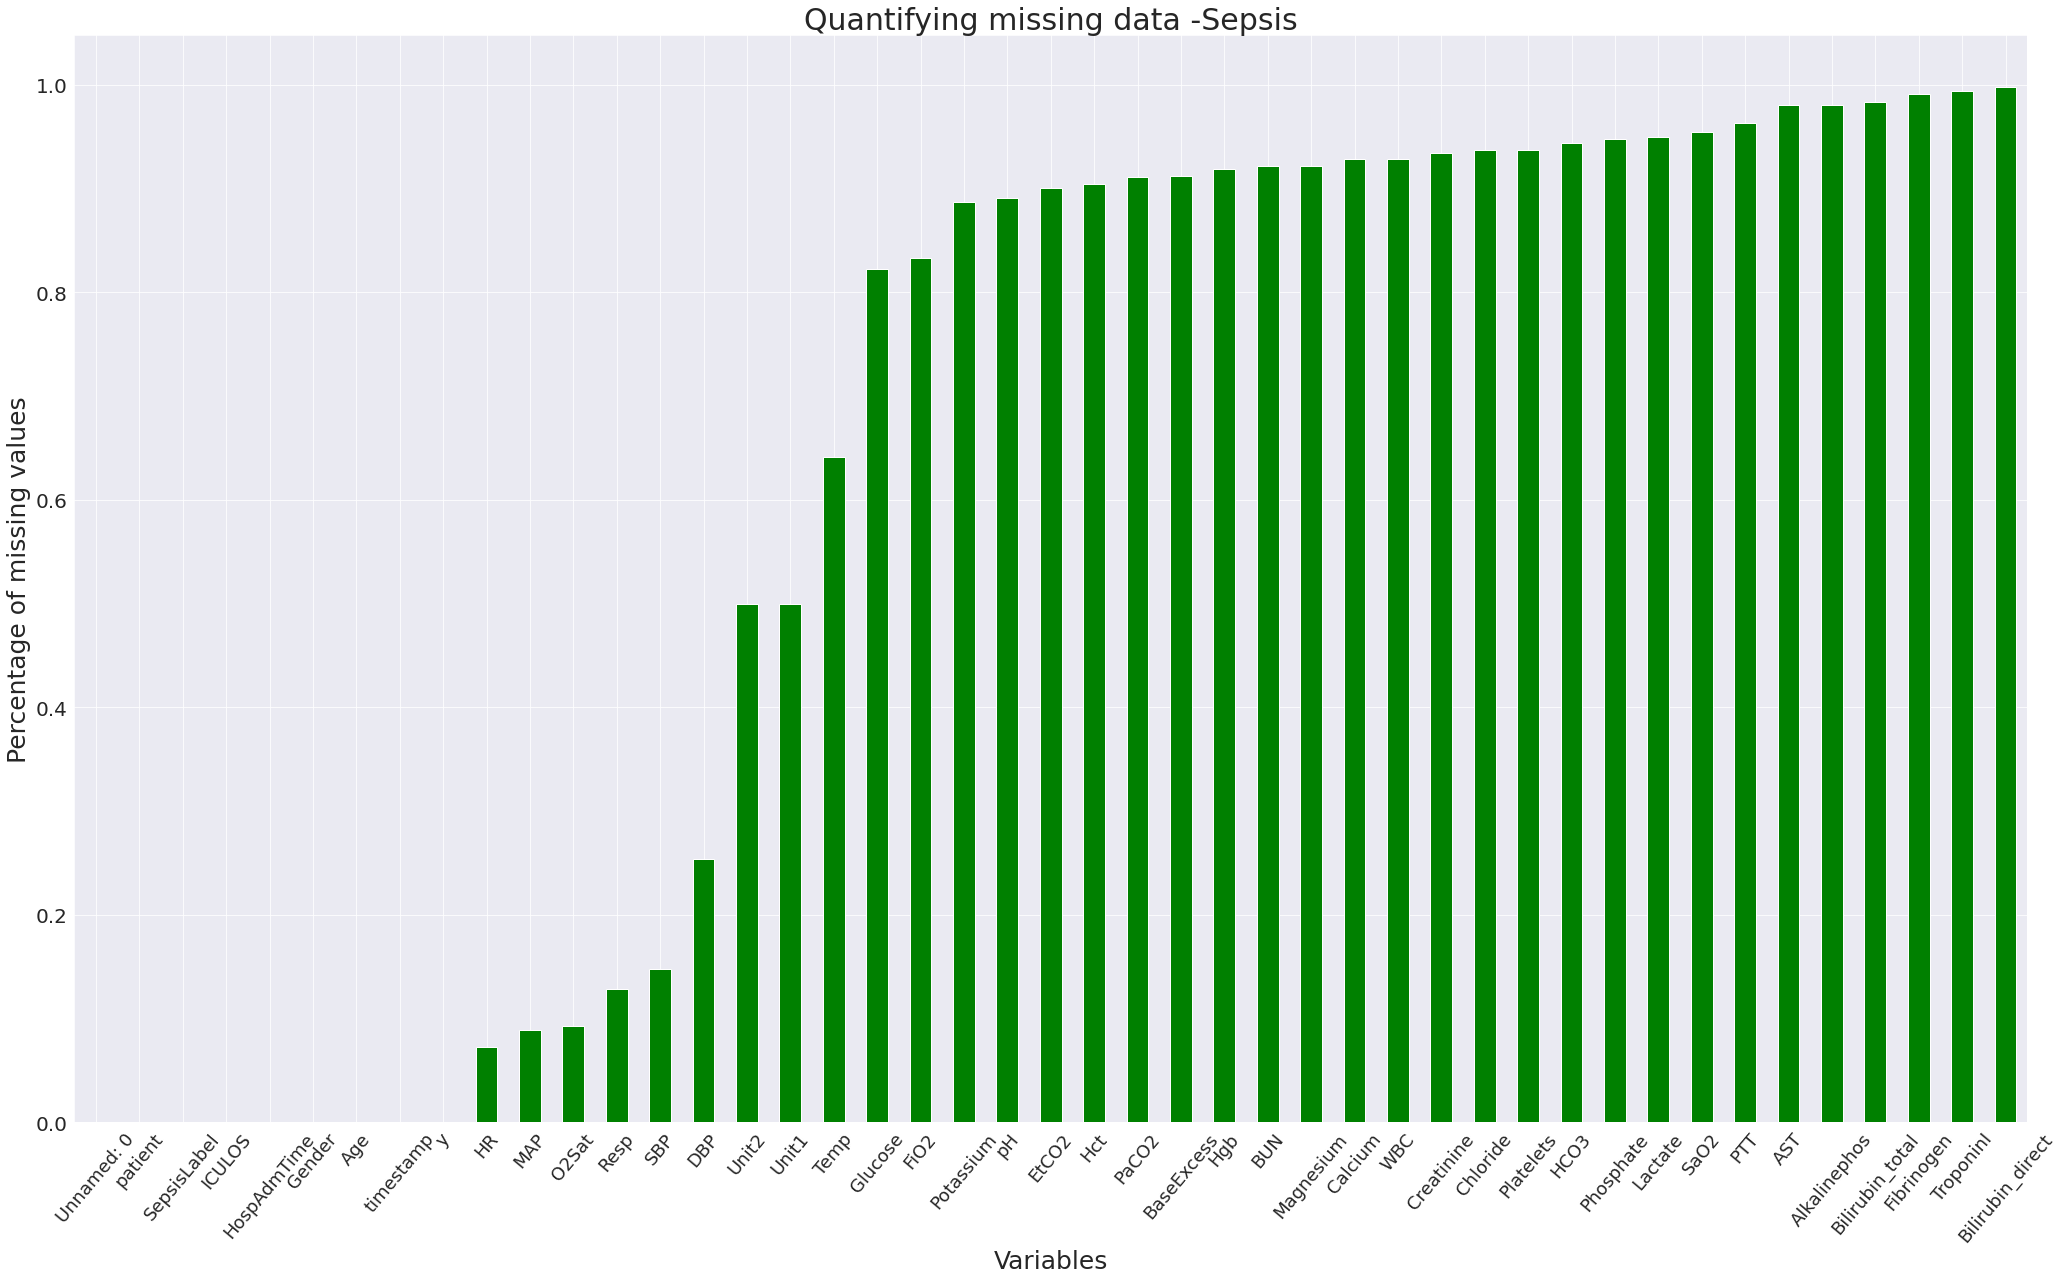

In [40]:
sick_df_training.isnull().mean().sort_values().plot.bar(figsize=(35,20), color='green')
plt.ylabel('Percentage of missing values', fontsize = 25)
plt.xlabel('Variables', fontsize = 25)
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 18, rotation= 50)
plt.title('Quantifying missing data -Sepsis', fontsize=30)

Text(0.5, 1.0, 'Quantifying missing data - NoSepsis')

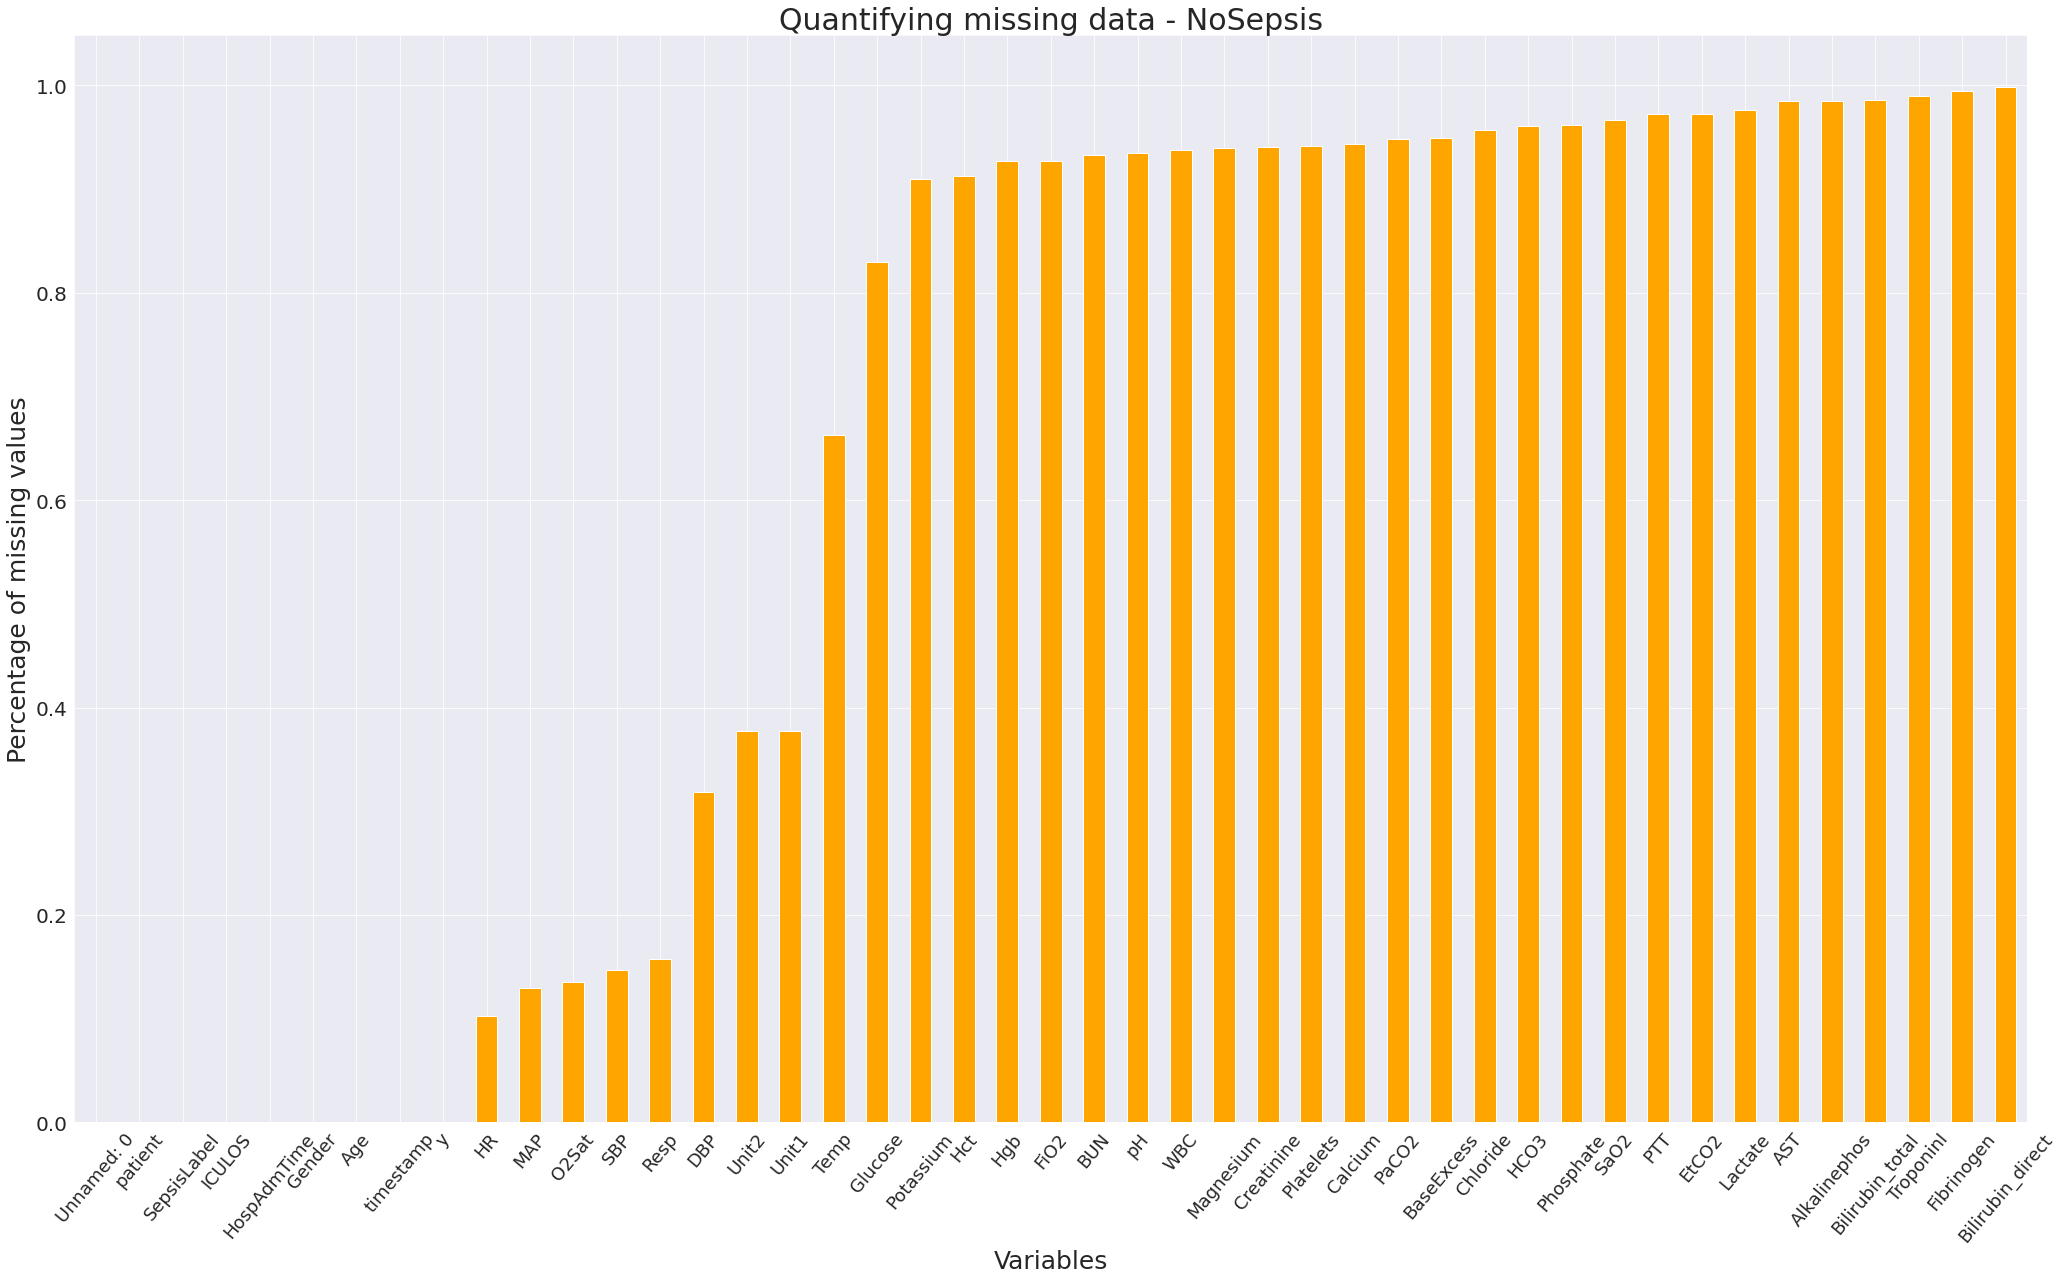

In [41]:
healthy_df.isnull().mean().sort_values().plot.bar(figsize=(35,20), color='orange')
plt.ylabel('Percentage of missing values', fontsize = 25)
plt.xlabel('Variables', fontsize = 25)
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 18, rotation= 50)
plt.title('Quantifying missing data - NoSepsis', fontsize=30)

<font size="4">

## Conclusions about the missing data:
We can see that the distribution of missing data is quite similar in both sepsis and no-sepsis patients. This is good because we can assume MCAR missing mechanism. 

When missing data is MCAR (Missing Completely At Random), This means that the probability of missing data does not depend on any observed or unobserved variables in the dataset. 

This is good news because it means that we can use various imputation methods to estimate the missing values without introducing any bias into our analyses.

# Handling missing data

<font size="3">

## We developed three imputation methods as follows:

### 1. Mean Imputation: 

We use the mean value of a column to fill in the missing values for that column.

### 2. Time Series Bucketing and Mean Imputation: 

This imputation method considers the time series aspect of each patient's data in the ICU. Initially, we divide the time series into three segments or "buckets." 

For instance, if patient_x has 30 rows of data with timestamps from 0-30, we split the full multivariate time series data into 3 buckets:
 - 0-10
 - 11-20
 - 21-30

Then, we calculate the mean value of each bucket.
Next, we impute each raw time series multivariate feature using one of two methods:

a.<u> Per-patient imputation:</u> If the patient has enough non-null values within the features (at least 5), we use the patient's own data to impute. We map each raw value to the corresponding bucket and impute with the patient bucket's aggregative value.

b. <u> General imputation:</u> If the patient doesn't have enough non-null values (less than 5), the bucketing mechanism is not reliable enough since the patient data is insufficient. Thus, we fill in the missing values with the average value of all patients' values within that bucket (calculated beforehand on all patients).

### 3. Imputation by Patient Group: 

During data analysis, we classified patients into three groups - fast, medium, and slow - based on their time spent in the ICU. To fill in missing values for a given patient, we use the average value of the corresponding feature with constaint on the patient group.

# Feature Enrichment


### SIRS 

<font size="3">

In order to help identify cases of sepsis, we added a column to the dataset based on the SIRS (Systematic Inflammatory Response Syndrome) criteria. SIRS is a set of clinical signs and laboratory findings that can indicate the presence of an infection or inflammatory process. Specifically, SIRS is defined as the presence of two or more of the following: abnormal body temperature, heart rate, respiratory rate, or blood gas, and white blood cell count. We calculated the number of SIRS criteria that were met hourly for each patient and added this information as a new column to the dataset. The idea is that the more SIRS criteria that are met, the higher the likelihood that the patient is experiencing sepsis.

# Feature transformatoins - via Normaliztion/Aggregation

<font size="3">


#### Normalization refers to the process of aggregating the time series data for each patient into a single row of features. Two normalization methods were developed:

#### <u> 1. Bucketing: </u>

This method involves dividing the time series data into three buckets, using a specified method of aggregation such as mean, median or max, and computing the corresponding bucket values for each patient. 

For instance, if a patient has HR values of [61, 62, 63, 61, 62, 61, 75, 78, 78], 
the values can be split into three buckets (start, mid, end) - [61, 62, 63], [61, 62, 61], [75, 78, 78]. 
The mean of each bucket can then be computed - [62], [61.33], [77]. 

Three new columns (HR_B1, HR_B2, HR_B3) can be created with values from the bucket means, and the old column can be dropped.

#### <u> 2. Mean: </u>
This method involves computing the mean value of all timestamps for each feature, for each patient.

# Feature engineering

<font size="3">

We performed optimization on 3 different feature imputation and transformations (i.e normalization). Note that, our transformations include the creation of new features; thus it is relevant to this part of the discussion.
As we had 3 methods for imputation (Mean, WindowsMeanBucket, PatientBucket) and transformations (Mean, WindowsMeanBucket, WindowsMedianBucket), we created 9 sets of train, val sets (3*3), each one corresponding to a different combination of imputation-transformation method. 
Also, it is important to note that the "WindowsMeanBucket" and "WindowsMedianBucket" transformations, created for each original feature - 3 corresponding new features which represent the time dimension as explained in the transformation section.

We shall note that we didn't perform feature selection. This is b

# Models 
- We tried 4 types of models:
* **KNN** 
* **Random Forest** 
* **XGBOOST**
* **CATBOOST**

<font size="3">

**KNN**

<u> Hyperparmeter tuning on k's between 1 to 24 </u>

Also, we performed min max scaling on the data set in order to endure a good capture of distances by the knn classifier

<font size="3">


**Random Forest**
- <u> Hyperparmeter tuning: </u>
    - max_depths: [40, 50, 80 ,100, 150, 200, 300]
    - number estimators: [25, 50, 100, 150, 200, 300, 400]

</font>

<font size="4">
we used class weight parameter as balanced state

</font>


<font size="3">

**XGBoost**
- <u> Hyperparmeter tuning:</u>
    -  max_depths:  [40, 50, 80 ,100, 150, 200, 300]
    - n_estimators: [25, 50, 100, 150, 200, 300, 400, 500]
    - sub_sample: [0.5, 0.6, 0.7, 0.8, 0.9, None]

- We used the following parameters **without** tuning: 
    - scale_pos_weight = 13  - because in our data there is 13 times more NoSepsis patients then Sepsis patients
    - max_delta_step = 0.15


**CATBoost**
- We attempted to optimize the same set of hyperparameters used in XGBoost for the CATBoost model, but with different values that were more suitable for CATBoost. However, the training process proved to be too time-consuming and the initial results were not as promising as those from XGBoost. As a result, we decided not to pursue further training of the CATBoost model


# Training and validation procedure

<font size="3">

To adhere to best practices, we conducted a train-validation split before commencing training. We split the data based on patient ID, assigning 70% of patients (14000) to the training set and 30% (6000) to the validation set. This approach ensures that no patient appears in both sets.

During each iteration, we tested a specific set of hyperparameters on the validation set, experiment datasets (one for each imputation-transformation combination), and model. Since each model had its own unique set of hyperparameters, we repeated this process for each one.

### Experiment datasets

| Experiment | Imputation | Feature normalization/aggregation |
|------------|------------|-----------------------------------|
| 0          | Mean       | Mean                          |
| 1          | PatientBucket     | Mean                  |
| 2          | WindowsMeanBucket | Mean                          |
| 3          | Mean | WindowsMeanBucket                 |
| 4          | PatientBucket       | WindowsMeanBucket                              |
| 5          | WindowsMeanBucket     | WindowsMeanBucket                              |
| 6          | WindowsMeanBucket | WindowsMedianBucket                             |
| 7          | PatientBucket | WindowsMedianBucket                            |
| 8          | Mean       | WindowsMedianBucket                           |

## Training and validation results

## Results of optimzation on hyperparameters and feature transformations:

<font size="3">

#### Best Model:

**xgboost** with the following set of parameters:
- max_depths = 80
- n_estimators = 400
- sub_sample = 0.8

#### Best set transformation-imputation:

**imputation**: WindowsMeanBucket

**transformation**: WindowsMeanBucket

With F1 score of: 0.734 on validation set 

We would like to point out that we were not taken aback by the outcome, given that XGBoost has been regarded as the state-of-the-art (SOTA) algorithm for handling tabular data for many years. 

Additionally, we had hypothesized beforehand that the more intricate types of imputations and transformations would yield the best results, since they also capture the temporal dimension. 

The **WindowsMeanBucket** transformation also incorporated more features compared to Mean, indicating that the more effort we put into feature engineering, the better the results are likely to be.

## KNN 

In [63]:
knn_results = {}
for i in range(4,13):
    with open(f'KNN/results_dict_experiment_{i}.txt', 'r') as f:
        data = f.read()
        dict_tmp = json.loads(data)
        dict_tmp =dict_tmp['KNN'][2]
        dict_tmp= dict(sorted(dict_tmp.items()))
        f1_scores = dict_tmp.values()
        knn_results[str(i)] = f1_scores

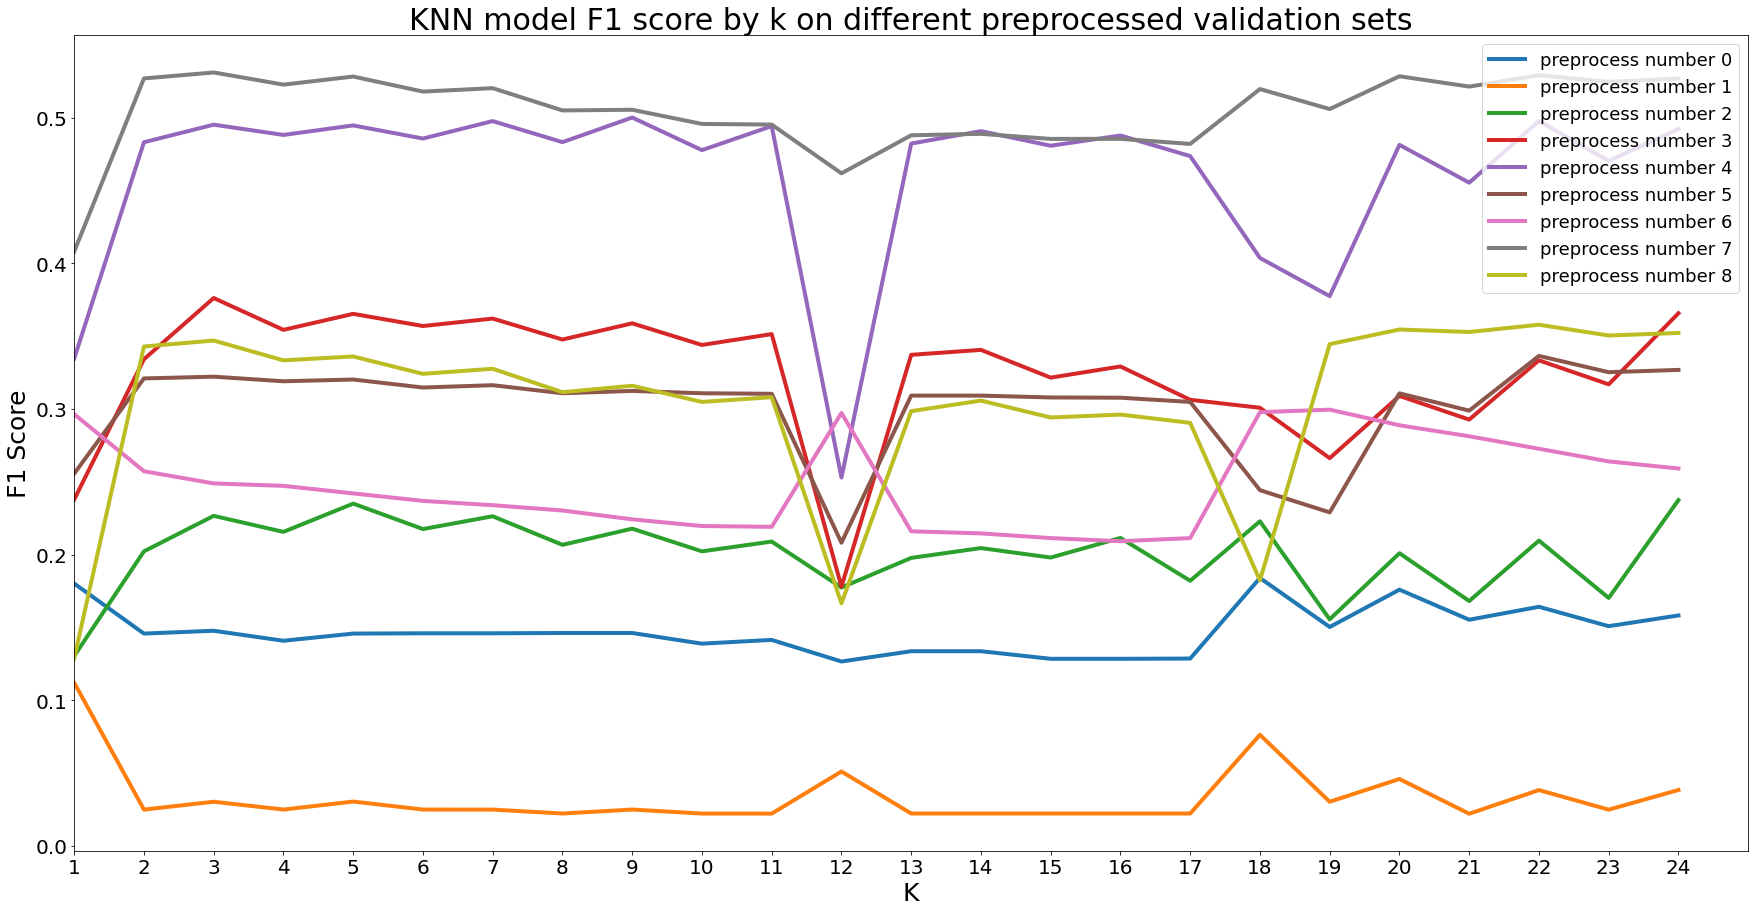

In [65]:
plt.figure(figsize=(30, 15))
for j, key in enumerate(knn_results.keys()):
    # Get the f1 scores for the current key
    f1_scores = knn_results[key]
    
    # Create a list of indices for the x-axis
    x_indices = [i+1 for i in range(len(f1_scores))]
    
    # Plot a line chart of the f1 scores
    plt.plot(x_indices, f1_scores, label=f"preprocess number {j}", linewidth=4)

# Add labels and legend to the plot
plt.xlabel('K', fontsize=25)
plt.ylabel('F1 Score', fontsize=25)
plt.xlim((1,25))
plt.xticks(range(1,25),fontsize=20)
plt.yticks(fontsize=20)
plt.title("KNN model F1 score by k on different preprocessed validation sets", fontsize=30)
plt.legend(loc='upper right', fontsize=18)

# Show the plot
plt.show()

Unlike in XGB and RF models here we can see that the best set was set number 7, that performs not bad. 
Also, we can see that k = 12 performs poorly for all data sets, and k = 2 or k = 3 performing best for all data sets.  

## Random Forest
We will plot only the results for max_depth = 200 and see how the change of number estimators affected the results on the validation set

In [32]:
rf_results = {}
for i in range(4,13):
    with open(f'RF/results_dict_experiment_{i}.txt', 'r') as f:
        data = f.read()
        dict_tmp = json.loads(data)
        dict_tmp =dict_tmp['RF'][2]
        dict_tmp= dict(sorted(dict_tmp.items()))
        f1_scores = dict_tmp.values()
        rf_results[str(i)] = f1_scores

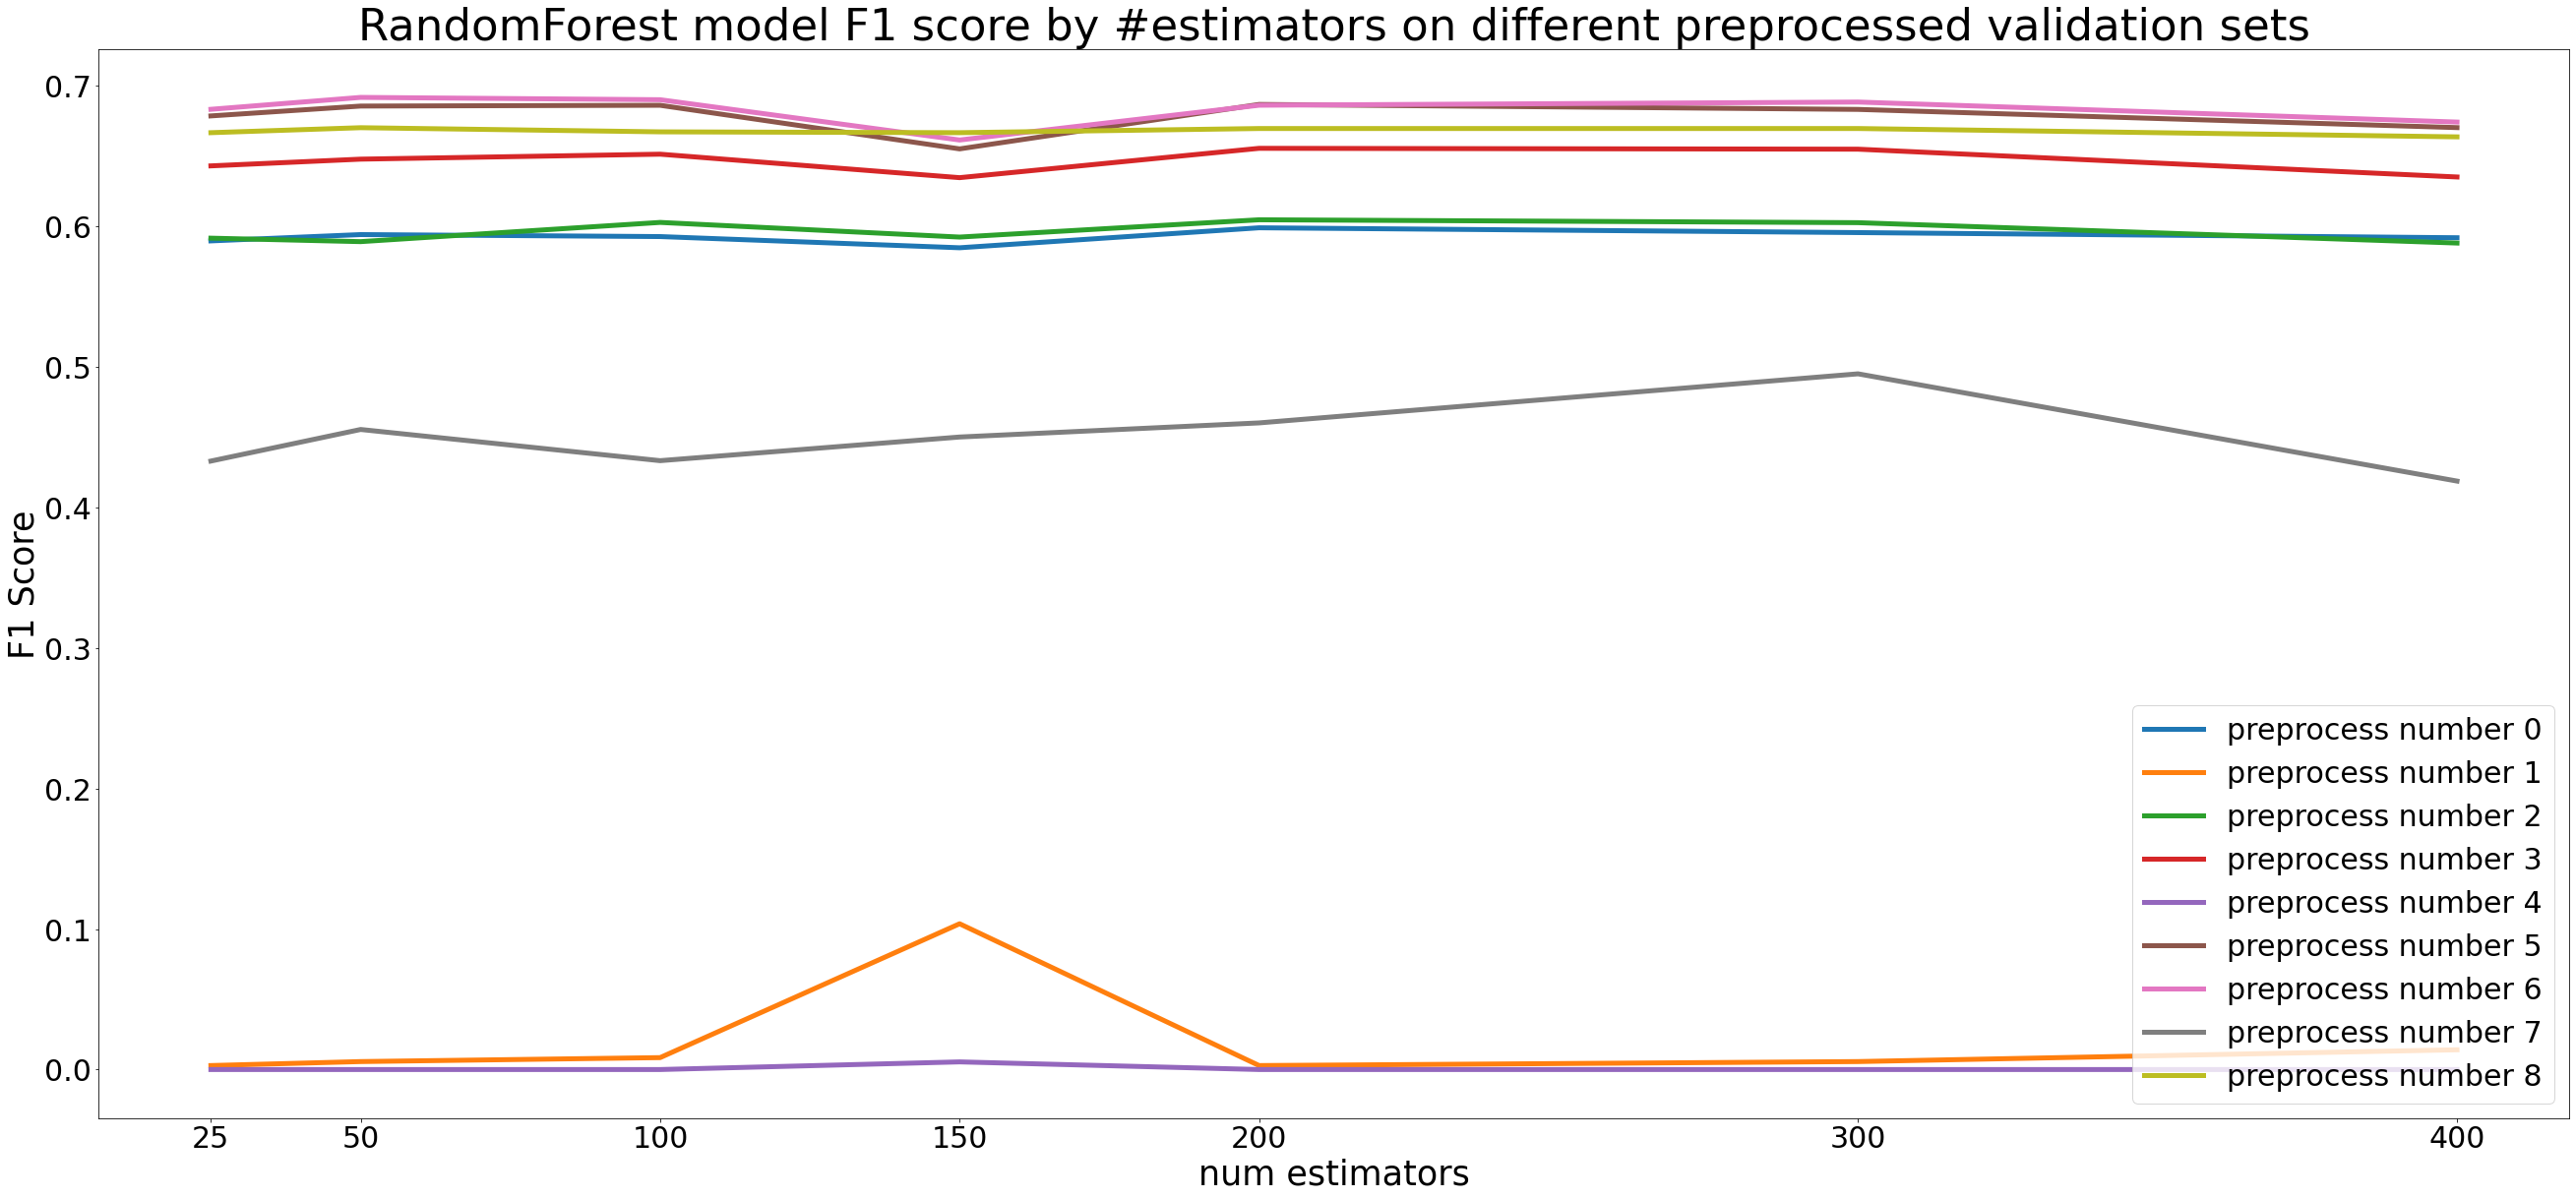

In [69]:
plt.figure(figsize=(45, 20))
n_estimators = [25, 50, 100, 150, 200, 300, 400]
for j, key in enumerate(rf_results.keys()):
    # Get the f1 scores for the current key
    f1_scores = rf_results[key]
    
    # Create a list of indices for the x-axis
    x_indices = n_estimators
    
    # Plot a line chart of the f1 scores
    plt.plot(x_indices, f1_scores, label=f"preprocess number {j}", linewidth=5)

# Add labels and legend to the plot
plt.xlabel('num estimators', fontsize=35)
plt.ylabel('F1 Score', fontsize=35)
plt.xticks(x_indices,fontsize=30)
plt.yticks(fontsize=30)
plt.title("RandomForest model F1 score by #estimators on different preprocessed validation sets", fontsize=45)
plt.legend(loc='lower right', fontsize=30)

# Show the plot
plt.show()

It is noteworthy that the optimal dataset, or preprocessing technique, for the XGBoost model also yielded preety good results for the RF model.

## XGB

In [60]:
xgb_results = {}
for i in range(4,13):
    with open(f'XGB/results_dict_experiment_{i}.txt', 'r') as f:
        data = f.read()
        dict_tmp = json.loads(data)
        dict_tmp =dict_tmp['XGB'][2]
        dict_tmp= dict(sorted(dict_tmp.items()))
        # f1_scores = dict_tmp.values()
        xgb_results[str(i)] = dict_tmp

# print(xgb_results)
xgb_dict ={}
n_estimators = [25, 50, 100, 150, 200, 300, 400, 500]
for i in range(4, 13):
    xgb_dict[str(i)] = []
    for est in n_estimators:
        # dict_tmp = xgb_results[str(i)]
        f1_score = xgb_results[str(i)][str(est) + ' ' + str(80) + ' ' + '0.8']
        xgb_dict[str(i)].append(f1_score)

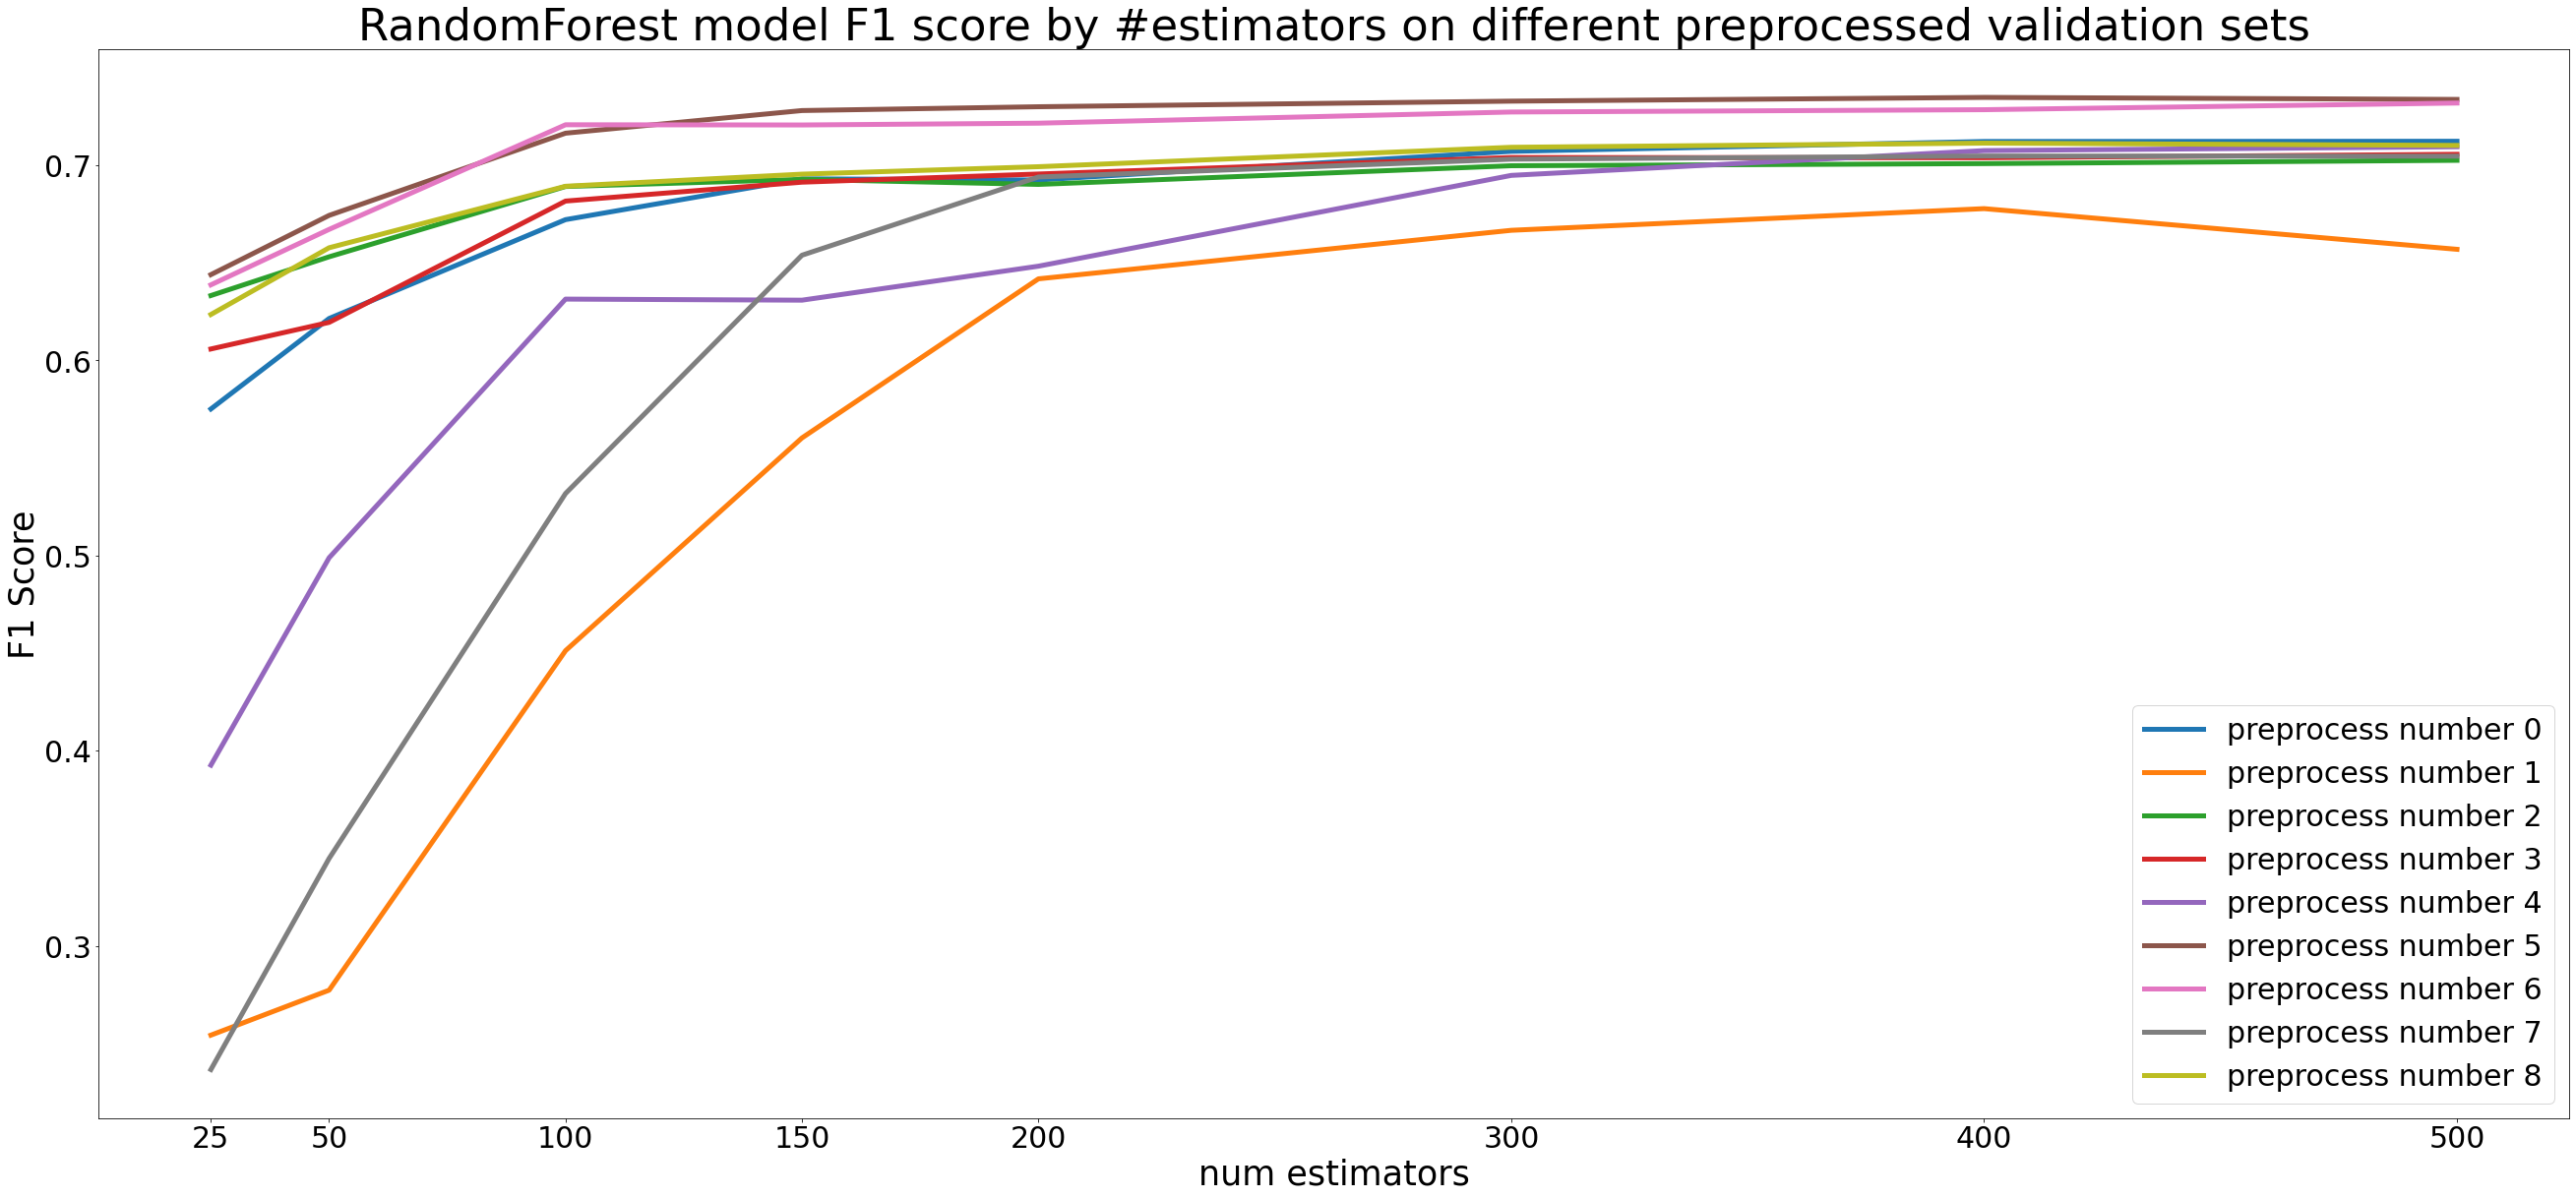

In [61]:
plt.figure(figsize=(45, 20))
for j, key in enumerate(xgb_dict.keys()):
    # Get the f1 scores for the current key
    f1_scores = xgb_dict[key]
    
    # Create a list of indices for the x-axis
    x_indices = n_estimators
    
    # Plot a line chart of the f1 scores
    plt.plot(x_indices, f1_scores, label=f"preprocess number {j}", linewidth=5)

# Add labels and legend to the plot
plt.xlabel('num estimators', fontsize=35)
plt.ylabel('F1 Score', fontsize=35)
plt.xticks(x_indices,fontsize=30)
plt.yticks(fontsize=30)
plt.title("XGBoost model F1 score by #estimators on different preprocessed validation sets", fontsize=45)
plt.legend(loc='lower right', fontsize=30)

# Show the plot
plt.show()

<font size="3">


It is evident that the n_estimators parameter plays a significant role in the training process, but the preprocessing technique we use can be even more impactful, to the extent that it can nullify the effect of the n_estimators parameter, as it can be seen here.
Here we can see clearly that the best set is set number 5 through all n_estimators.

In [ ]:
cm = confusion_matrix(Y_test, y_pred, labels=xgboost.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Sepsis', 'Sepsis'])
disp.plot()
plt.show()

## Post Analysis

### Analyse F1 score on subpopulations

In [2]:
import json
import pandas as pd
import os
import sys
import pickle
import numpy as np
from sklearn.metrics import f1_score

In [3]:
results_dict = {"young adult (18-28)": 0.6957, "adult (28-40)": 0.76, "mature adult (40-57)": 0.5984, "old adult (57-80)": 0.6804, "very old (80+)": 0.6341}

In [4]:
ages_groups = {'child': list(range(0, 10)),
                   'youth': list(range(10, 18)),
                   'young adult': list(range(18, 28)),
                   'adult': list(range(28, 40)),
                   'mature adult': list(range(40, 57)),
                   'old adult': list(range(57, 80)),
                   'very old': list(range(80, 120)),
                   }

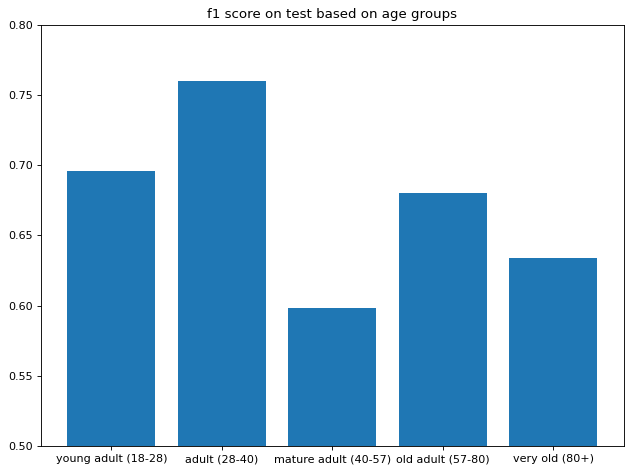

In [22]:

from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.bar(*zip(*results_dict.items()))
plt.title("f1 score on test based on age groups")
plt.ylim(0.5,0.8)
plt.tight_layout()
plt.show()

In [9]:
test_df_transformed = pd.read_csv("test_df_transformed.csv")
ages_groups = {
                'young adult': list(range(18, 28)),
                'adult': list(range(28, 40)),
                'mature adult': list(range(40, 57)),
                'old adult': list(range(57, 80)),
                'very old': list(range(80, 120)),
                }
results_dict_counts = {}
for age_name, age_range in ages_groups.items():
    rel_test = test_df_transformed[test_df_transformed.Age.isin(age_range)]
    results_dict_counts[age_name] = len(rel_test)
    

In [19]:
train_df_filtered = pd.read_csv("train_df_filtered.csv")
train_df_filtered_clean = train_df_filtered[["patient", 'Age']].drop_duplicates()
ages_groups = {
                'young adult': list(range(18, 28)),
                'adult': list(range(28, 40)),
                'mature adult': list(range(40, 57)),
                'old adult': list(range(57, 80)),
                'very old': list(range(80, 120)),
                }
results_dict_counts_train = {}
for age_name, age_range in ages_groups.items():
    rel_test = train_df_filtered_clean[train_df_filtered_clean.Age.isin(age_range)]
    results_dict_counts_train[age_name] = len(rel_test)
    

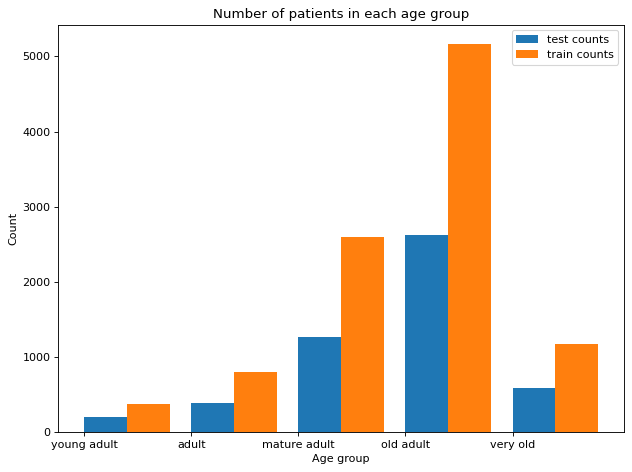

In [21]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

# Define the x-axis positions for the bars
x_test = range(len(results_dict_counts))
x_train = [x + 0.4 for x in x_test]

# Plot the bars
plt.bar(x_test, results_dict_counts.values(), width=0.4, align='edge', label='test counts')
plt.bar(x_train, results_dict_counts_train.values(), width=0.4, align='edge', label='train counts')

# Set the x-tick labels to be the age groups
plt.xticks(x_test, results_dict_counts.keys())

plt.title("Number of patients in each age group")
plt.xlabel("Age group")
plt.ylabel("Count")
plt.legend()

plt.tight_layout()
plt.show()

##  Model Interpretability

### shap value analysis

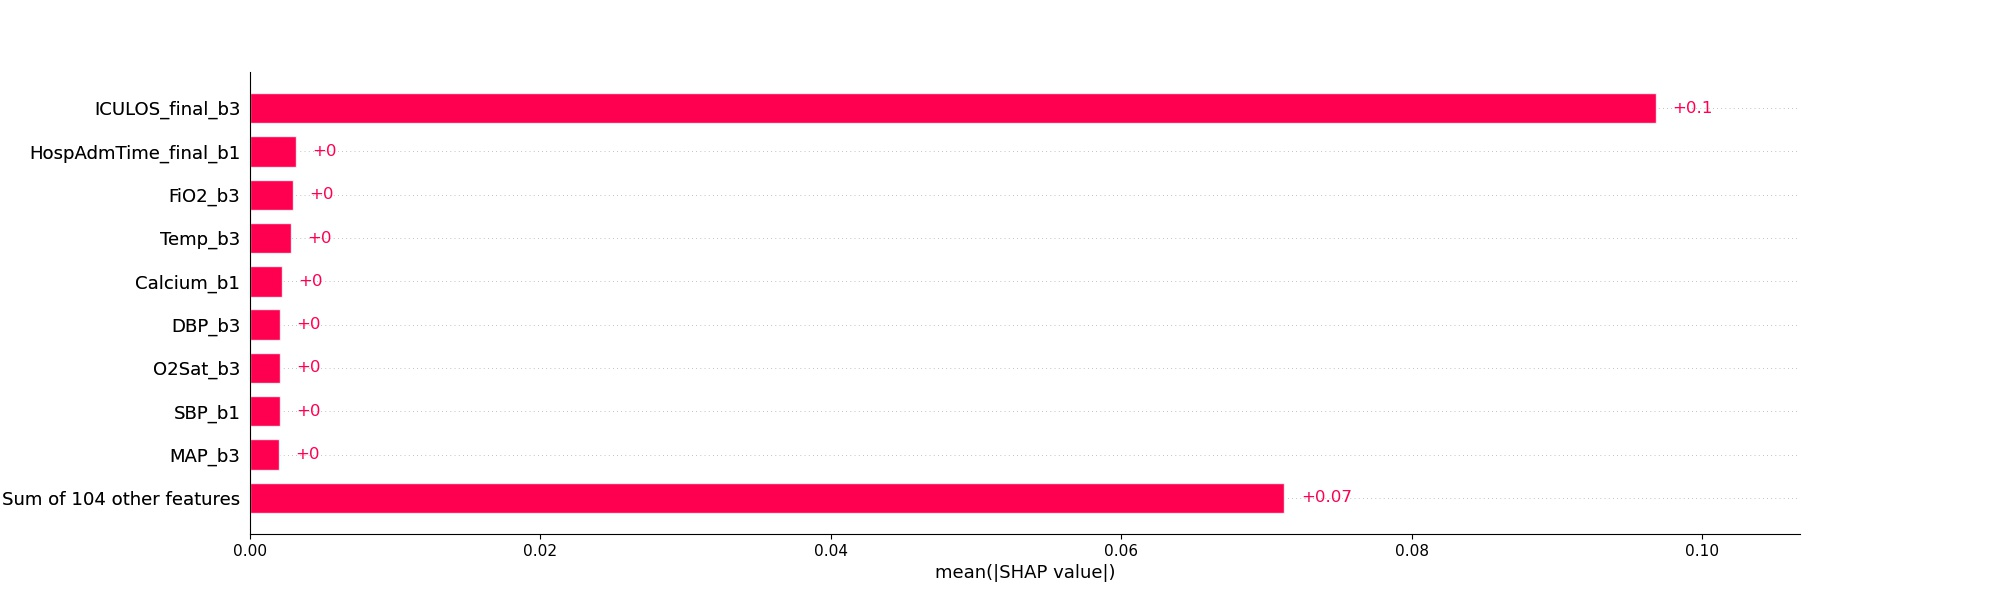

In [1]:
from IPython.display import Image
display(Image(filename='shap_values.jpg'))

we can see the 2 most dominant features were - ICULOS and HospAdmTime, which are as expected very indicative of the patient initial state.
Also the features which had the highest shap value belonged to b1 and b3, i.e the start of the ICU stay and the end of ICU stay.

## Summary and Discussion

<font size="3">

In our data science project, we performed several important steps, including data analysis, feature engineering, imputation, model selection, and post-hoc analysis. We dedicated significant time to each step, ensuring that we executed them comprehensively.

During the data analysis phase, we began by exploring the data and analyzing the different features while taking into account their data type. We then delved into the feature distribution and performed statistical tests to identify differences between sick and healthy patients. We recognized the importance of the temporal dimension and addressed it while preparing the train and validation datasets for training. Additionally, we observed that almost all features had missing values, some having more than 50% and going up to 90%. We determined a missingness mechanism, which was MCAR, allowing us to perform our chosen imputation methods.

In the feature engineering stage, we developed a new feature named SIRS and a method for encoding the temporal dimension into the tabular features using bucketing on the hours the patient spent in the ICU.

During the model selection phase, we performed hyperparameter optimization on three models' relevant parameters, and XGBoost outperformed the KNN and RandomForest models. We identified some parameters that had a higher influence on the f1 metric.

The model selection concluded that XGBoost is the most performant, with 0.734 on the validation set and 0.718 on the test set, where the difference between the two sets can be explained by the fact that distributions might be different between the train and the test.

Finally, in the post-hoc analysis stage, we examined subpopulations based on age and found that our model performed best on the age group of adults 28-40, and worst on mature adults 40-57. 

In conclusion, our project has demonstrated the importance and necessity of each step in the data science pipeline. Through our rigorous data analysis, feature engineering, imputation, model selection, and post-hoc analysis, we were able to gain a deep understanding of the underlying patterns in our data and develop a highly performant predictive model. Furthermore, our post-hoc analysis allowed us to identify specific subpopulations in which our model performed particularly well or poorly, which can inform future research and clinical decision-making. Overall, our project serves as a strong example of how the systematic application of data science principles can yield valuable insights and help to drive progress in healthcare and other fields.